In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from util import RuleClassifier, print_complexity, evaluate_counterfactual_fidelity
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order, print_rules
from clustering import make_clustering
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                               explanation_type='indiv', space_type='log_odds')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [33:03,  2.04s/it]                         

CPU times: user 1h 45min 23s, sys: 5min 58s, total: 1h 51min 22s
Wall time: 33min 3s


In [7]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [36:29,  2.25s/it]                         

CPU times: user 1h 44min 48s, sys: 6min 3s, total: 1h 50min 52s
Wall time: 36min 29s


# Traditional SHAP Explanations

In [5]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [6]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

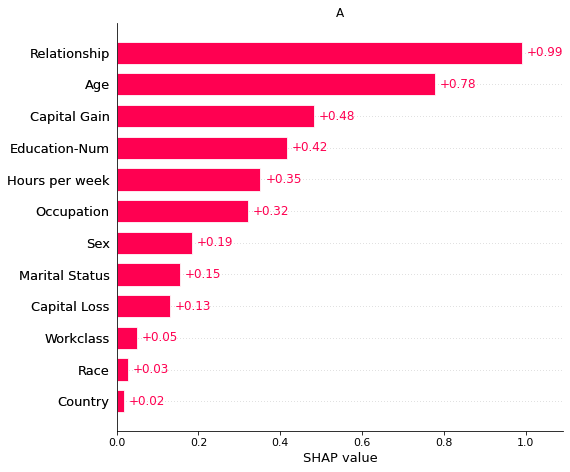

In [7]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

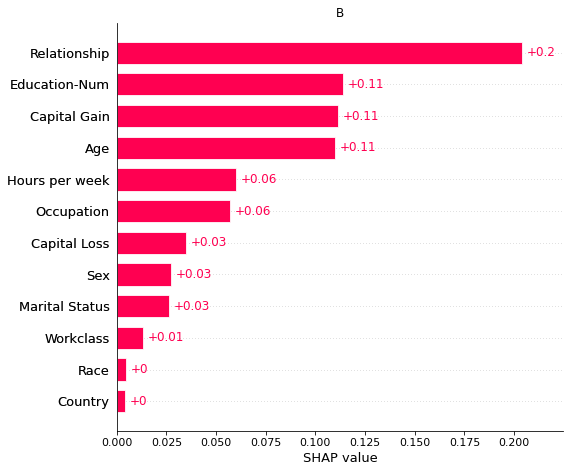

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [9]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 139 ms, sys: 15.9 ms, total: 155 ms
Wall time: 196 ms


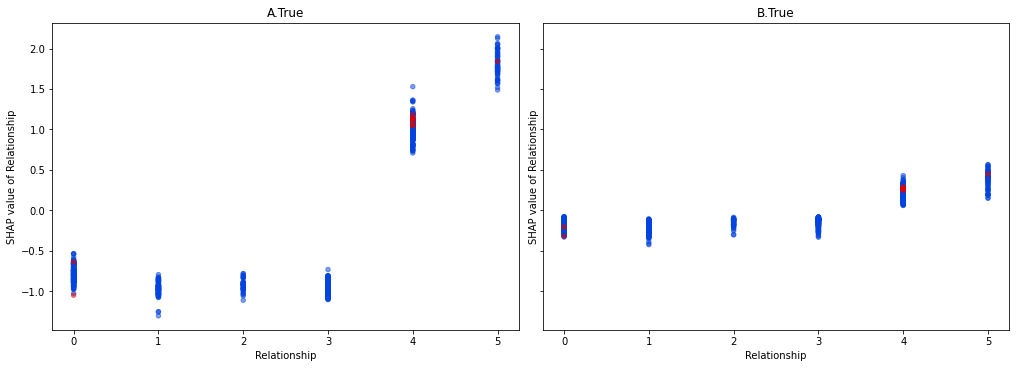

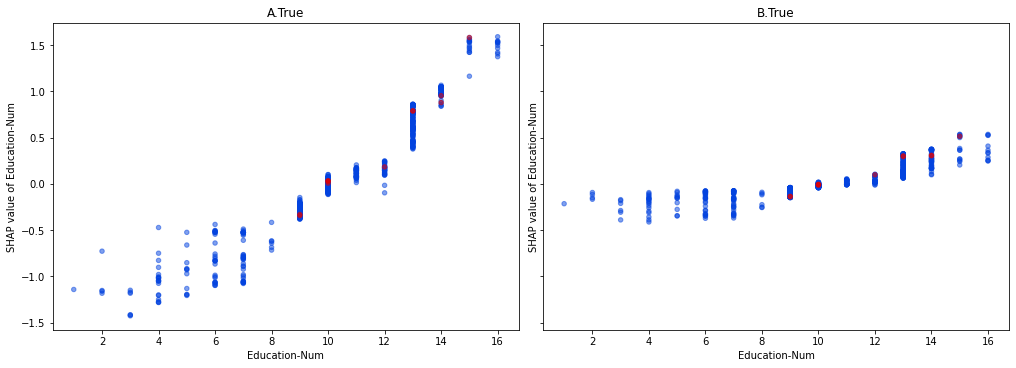

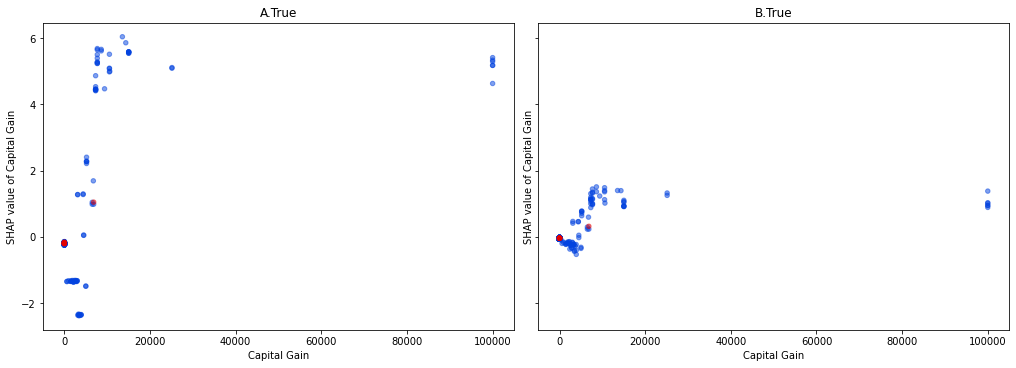

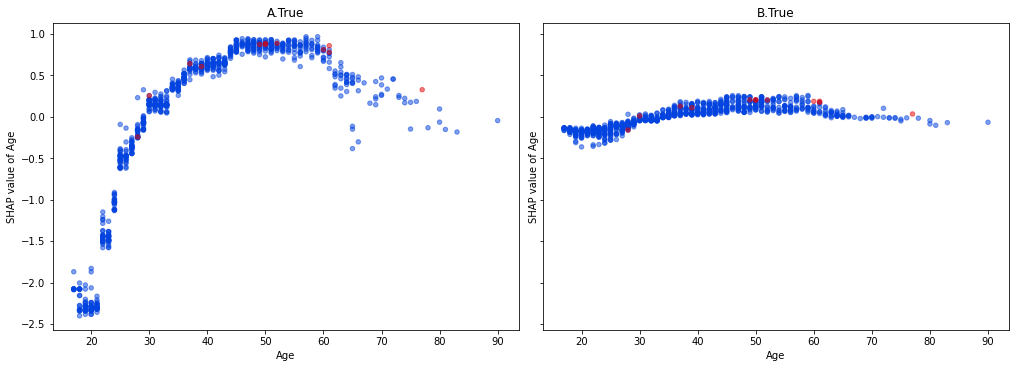

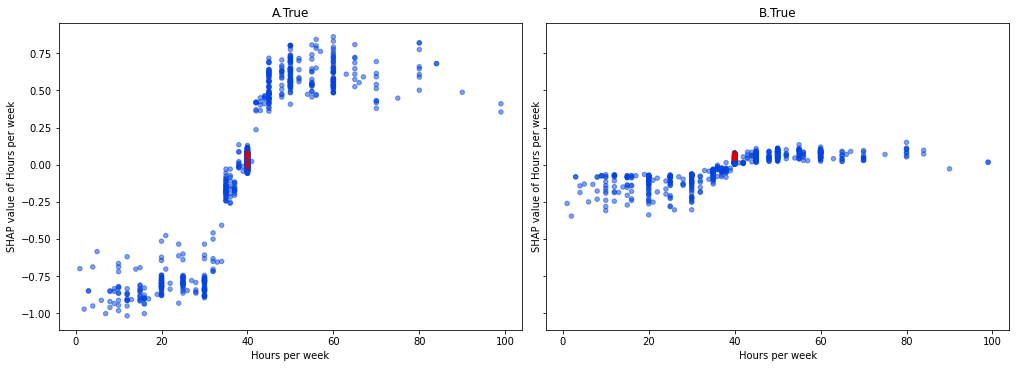

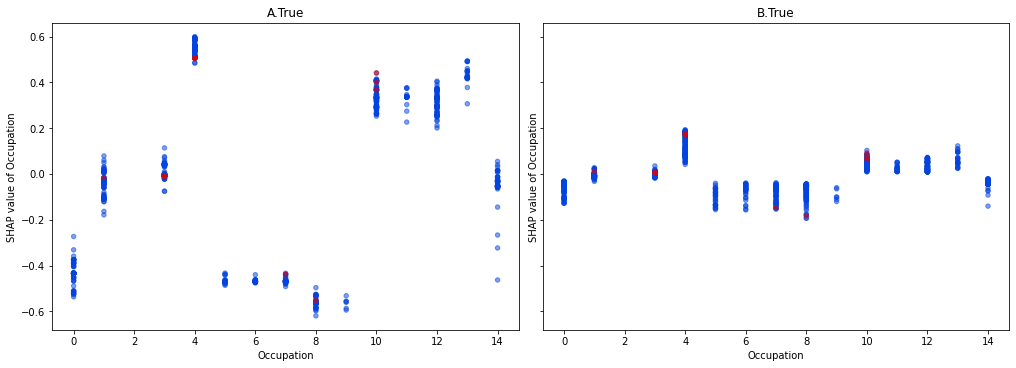

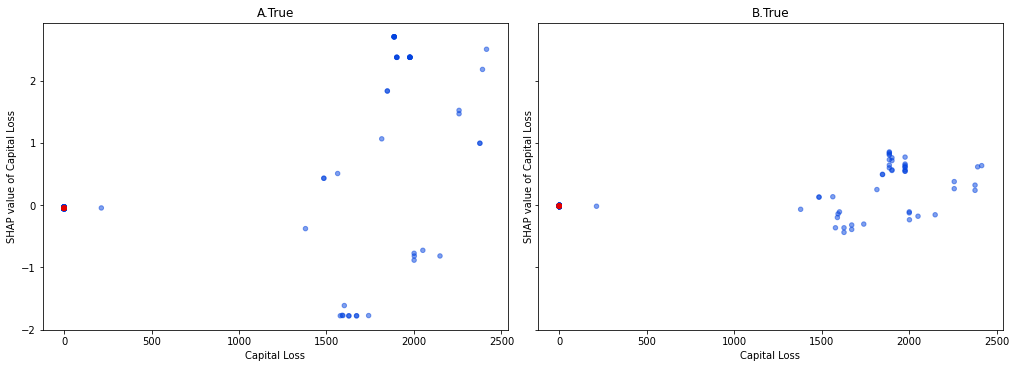

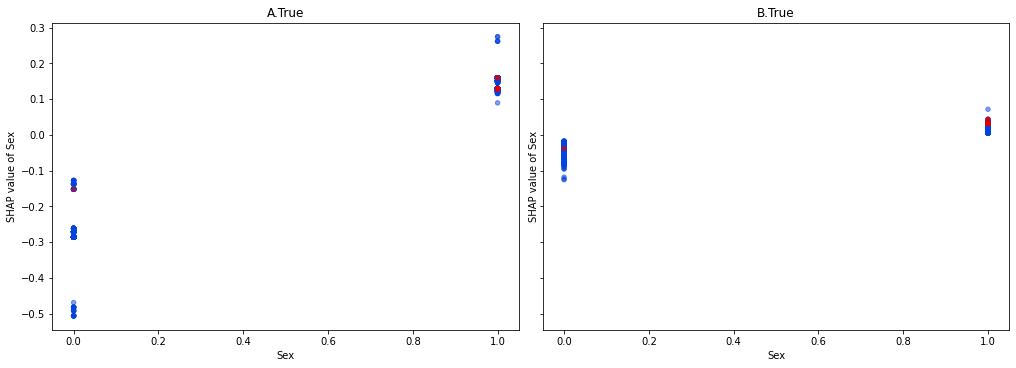

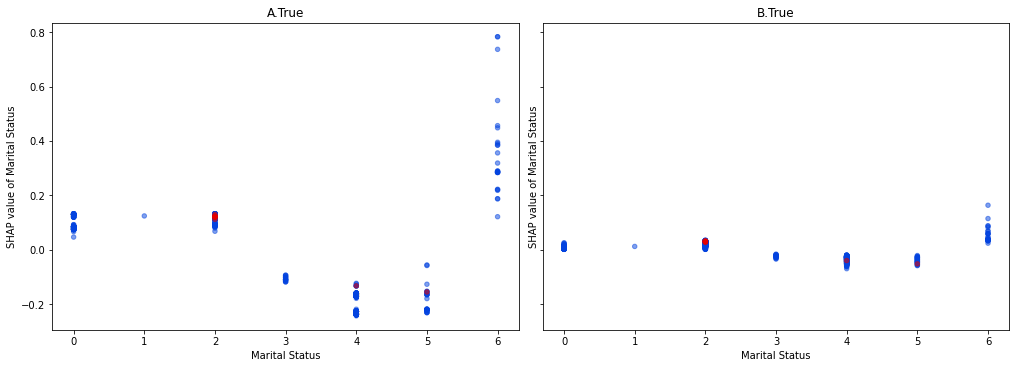

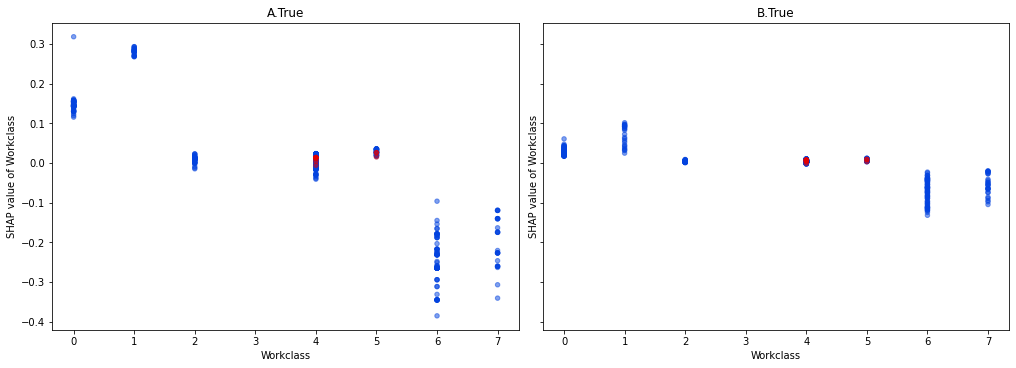

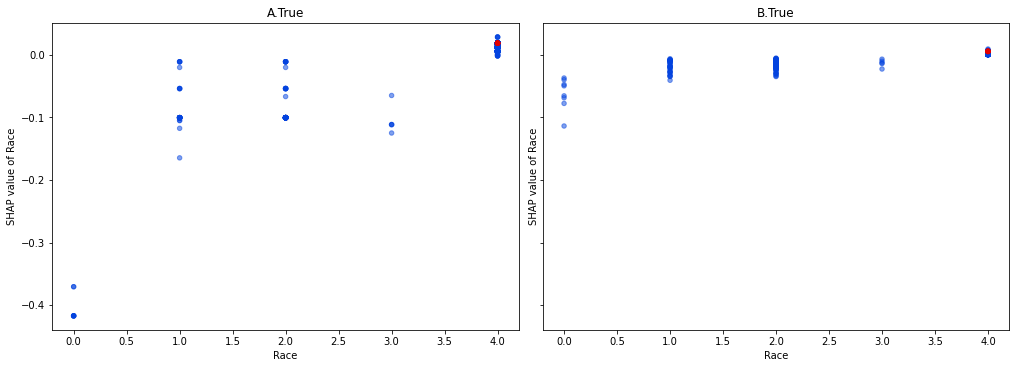

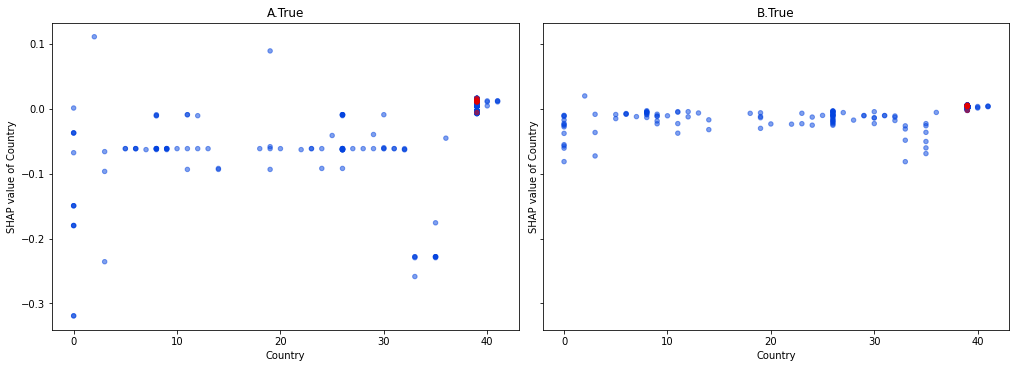

In [10]:
for feature in feature_order:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [5]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

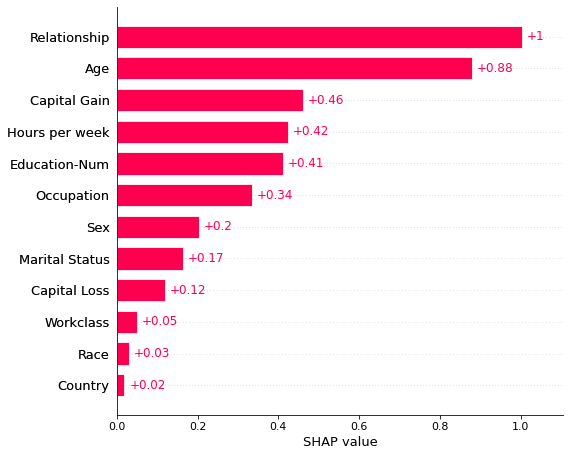

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

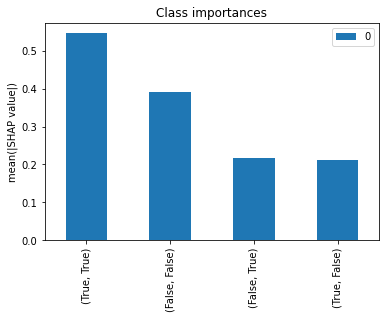

In [7]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [8]:
def plot(feature):
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

In [9]:
def plot_2d(node, x, y):
    comparer.plot_decision_boundaries(node.root.data, type='bin-diffclf', x=x, y=y, alpha=0.5, show=False)
    for cf in node.counterfactuals[x]:
        plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
    for cf in node.counterfactuals[y]:
        plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

## Clustering of Class $(False, True)$ SHAP Values

In [10]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(False, True)',
                       ['(False, False)', '(False, True)', '(True, True)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 6min 47s, sys: 32.8 s, total: 7min 19s
Wall time: 2min 51s


((False, False)    784
 (True, True)      181
 (False, True)      12
 dtype: int64,
 336.5608428431883)

In [12]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

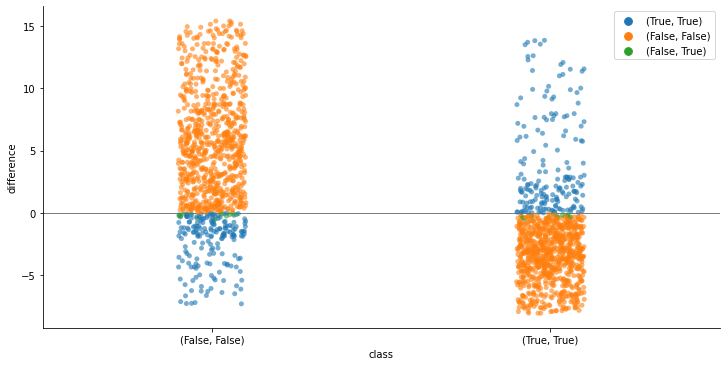

{'(False, False)': '-0.51 to -0.04', '(True, True)': '-0.53 to -0.11'}


In [13]:
node.plot_outcome_differences()

### Main Node (R)

In [14]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (False, False)    784
 (True, True)      140
 (False, True)      12
 dtype: int64,
 145.6227662418017)

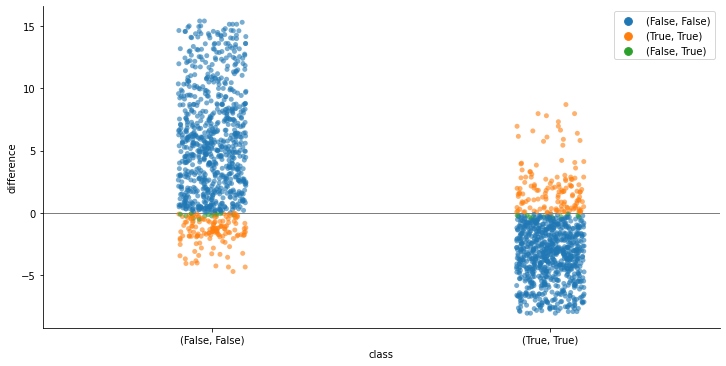

{'(False, False)': '-0.51 to -0.04', '(True, True)': '-0.53 to -0.11'}


In [15]:
node.plot_outcome_differences()

In [16]:
feature_it = iter(node.features_with_counterfactuals)

difference class has a broad global high similar to class $(True, True)$. Lower values have increased probability to be classified $(False, False)$.

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 12},
 Upper CF: Age == 80.0 --> {'(False, False)': 11, '(True, True)': 1}]


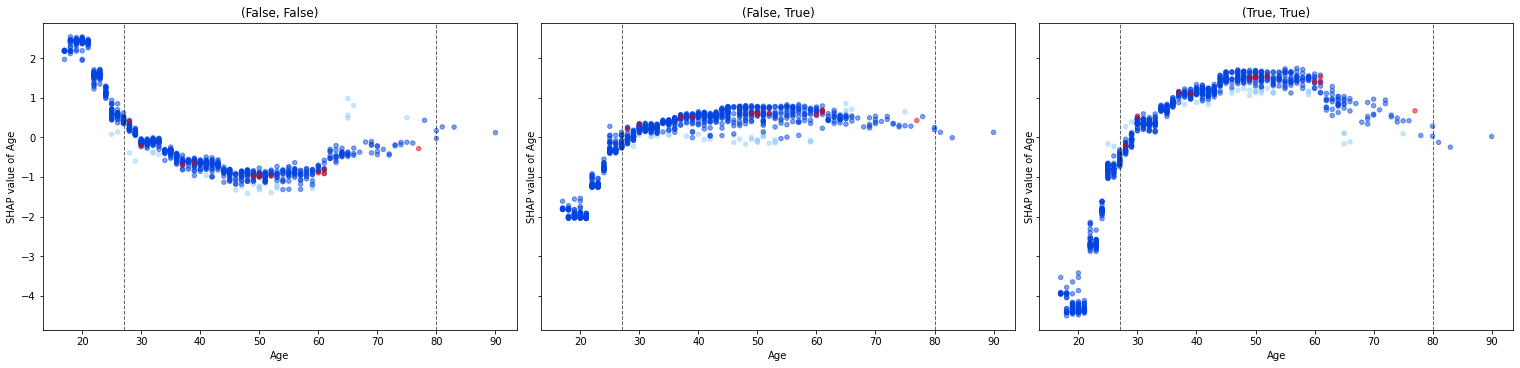

In [17]:
plot(next(feature_it))

difference class has a global high for high feature values, along with class $(True, True)$. All instances classified differently are $=40$ and would flip their prediction if they were 39 or 42.

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 12},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 12}]


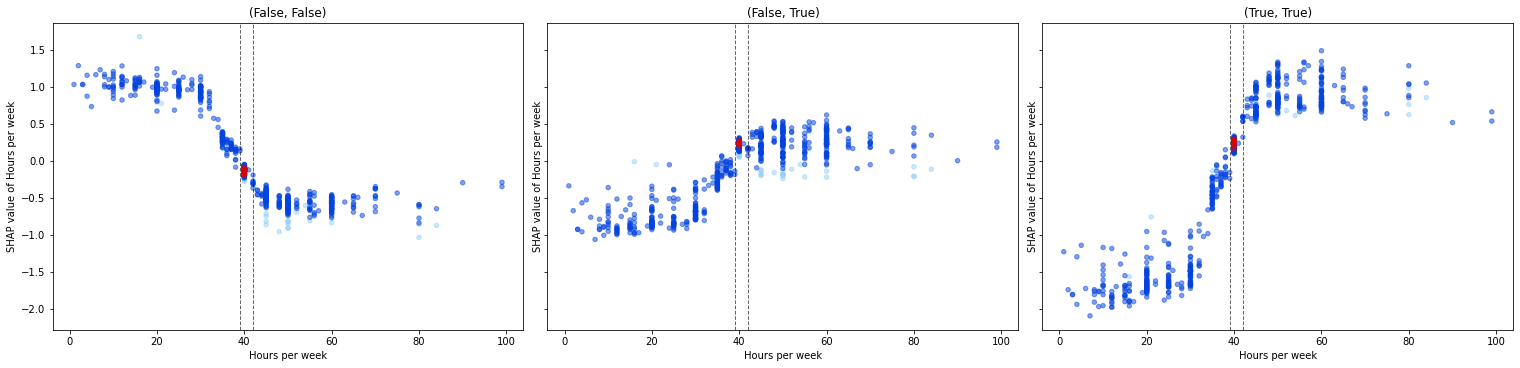

In [18]:
plot(next(feature_it))

difference class increase in outcome is steadily increasing, but with strong interaction effects present at high values. Instances classified differently have a wide range of higher values.

9.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 12}]


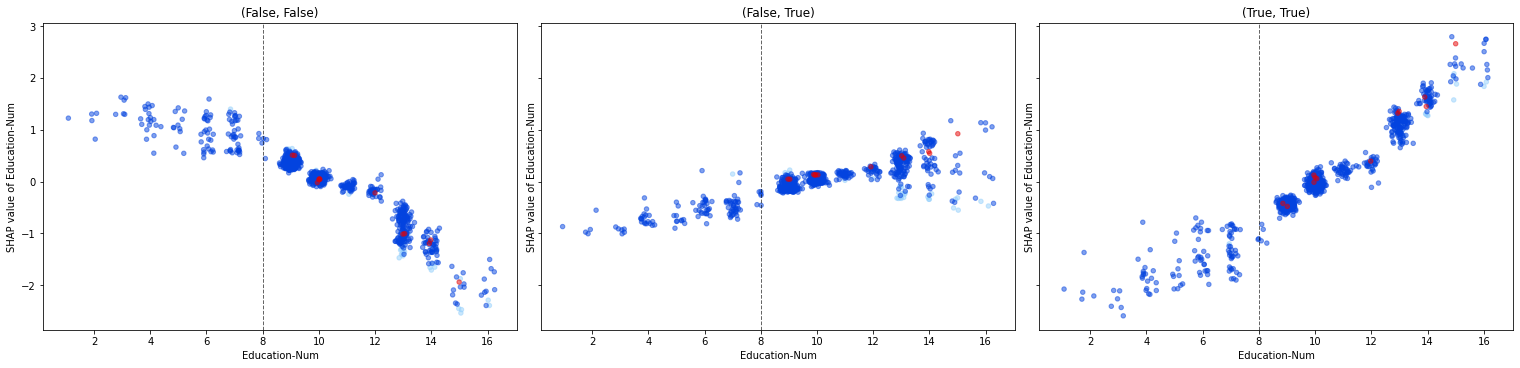

In [19]:
plot(next(feature_it))

above 7074, there is a high increase for class $(True, True)$, which makes them very unlikely for being classified differently.

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 12}]


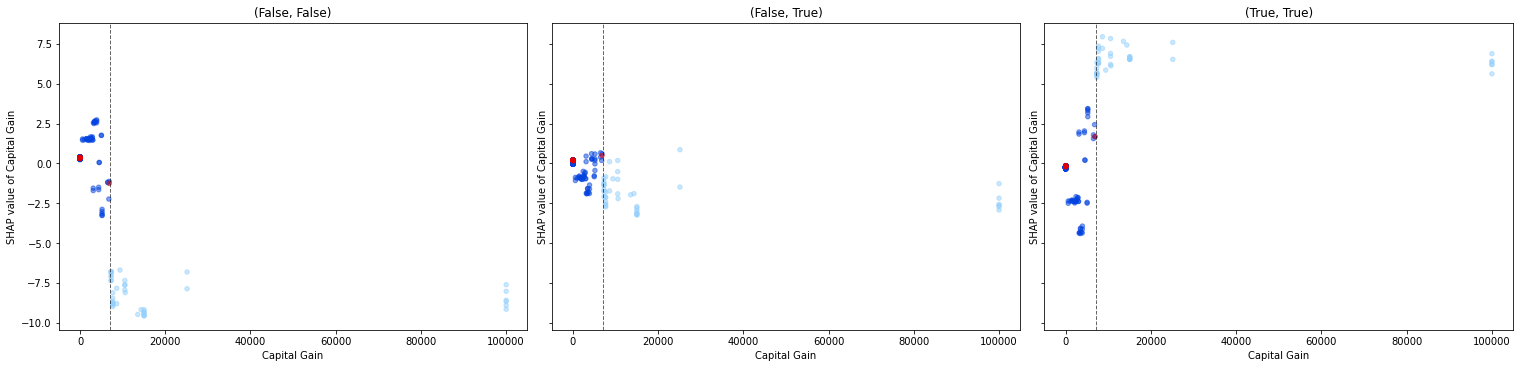

In [20]:
plot(next(feature_it))

CF is very outlying. skipping it for now.

2.0 <= Marital Status <= 5.0
[Upper CF: Marital Status == 6.0 --> {'(True, True)': 11, '(False, False)': 1}]


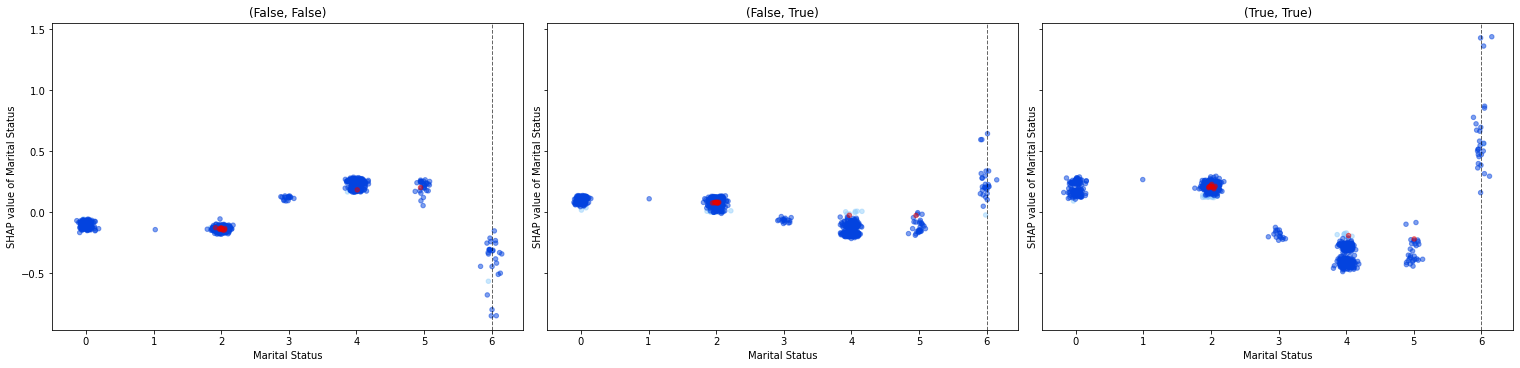

In [21]:
plot(next(feature_it))

No clear trend visible, skipping it.

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 12}]


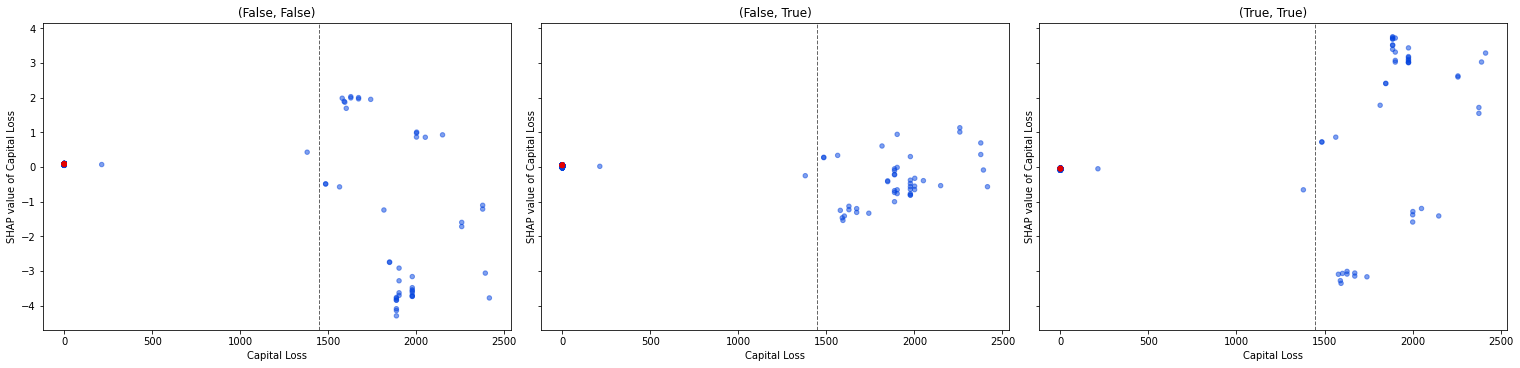

In [22]:
plot(next(feature_it))

Very outlying CF, skipping.

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 12}]


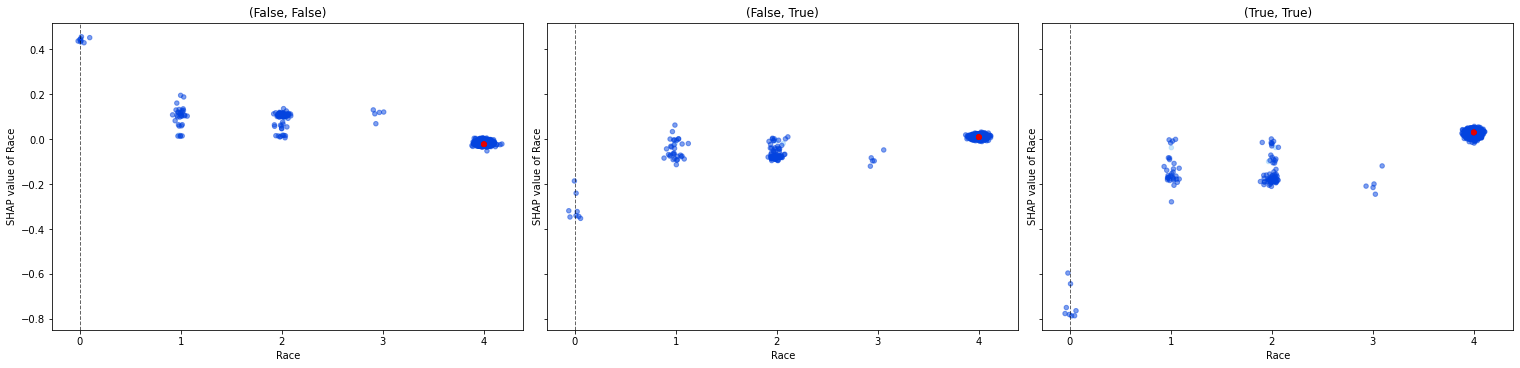

In [23]:
plot(next(feature_it))

27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.71      0.83       924
        True       0.04      1.00      0.08        12

    accuracy                           0.72       936
   macro avg       0.52      0.86      0.46       936
weighted avg       0.99      0.72      0.82       936



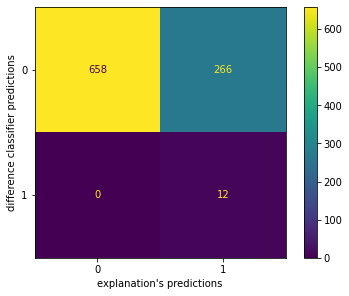

In [24]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Age', 'Hours per week', 'Education-Num', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

In [25]:
explanations_global = [(rule, constraint, instance_indices)]

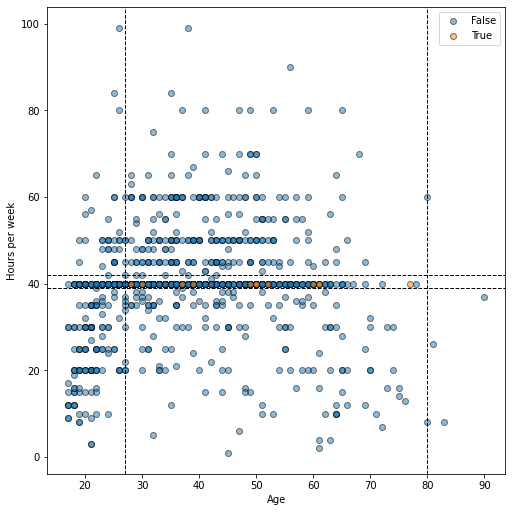

In [26]:
plot_2d(node, 'Age', 'Hours per week')

### Node 1 (RLRLR)

In [27]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLR,
 (False, False)    170
 (False, True)       2
 (True, True)        2
 dtype: int64,
 44.29419494339962)

The log odds estimates of these predictions are a bit closer to $(False, False)$ than to $(True, True)$.

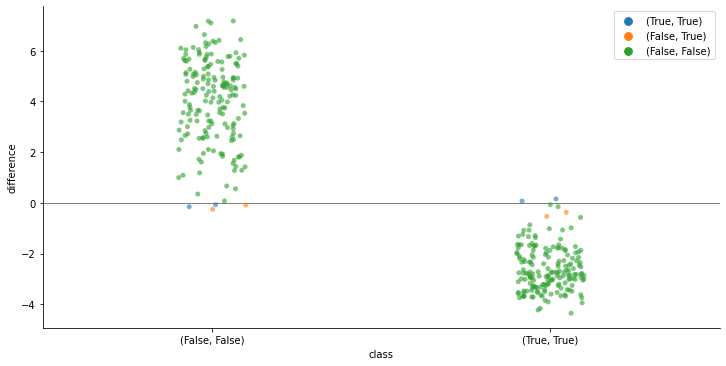

{'(False, False)': '-0.25 to -0.08', '(True, True)': '-0.53 to -0.37'}


In [28]:
node.plot_outcome_differences()

In [29]:
feature_it = iter(node.features_with_counterfactuals)

Relationship: $=0$, while most other instances classified differently are 4 or 5. Even there is not a pronounced effect visible, the prediction changes if set to 1.

Relationship == 0.0
[Upper CF: Relationship == 1.0 --> {'(False, False)': 2}]


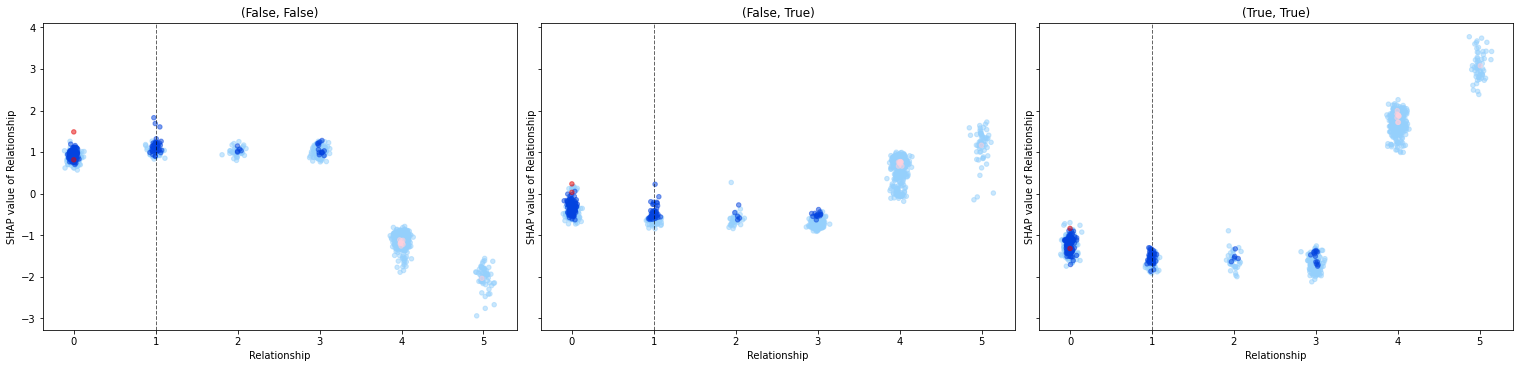

In [30]:
plot(next(feature_it))

CFs a bit narrower than in parent

39.0 <= Age <= 61.0
[Lower CF: Age == 36.0 --> {'(False, False)': 2},
 Upper CF: Age == 66.0 --> {'(False, False)': 2}]


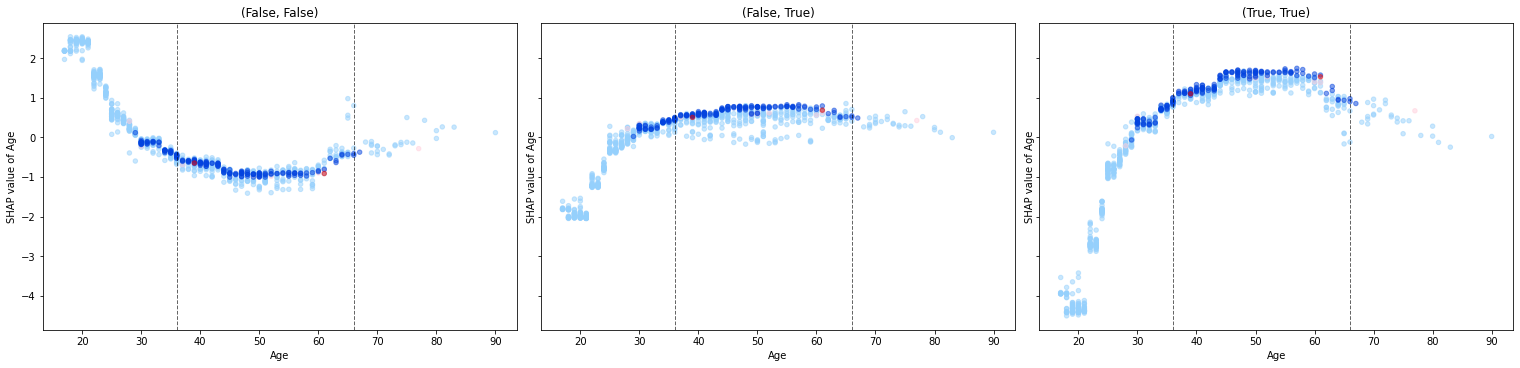

In [31]:
plot(next(feature_it))

Education-Num: is very high, prediction flips if set to 13 or lower.

14.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 13.0 --> {'(False, False)': 2}]


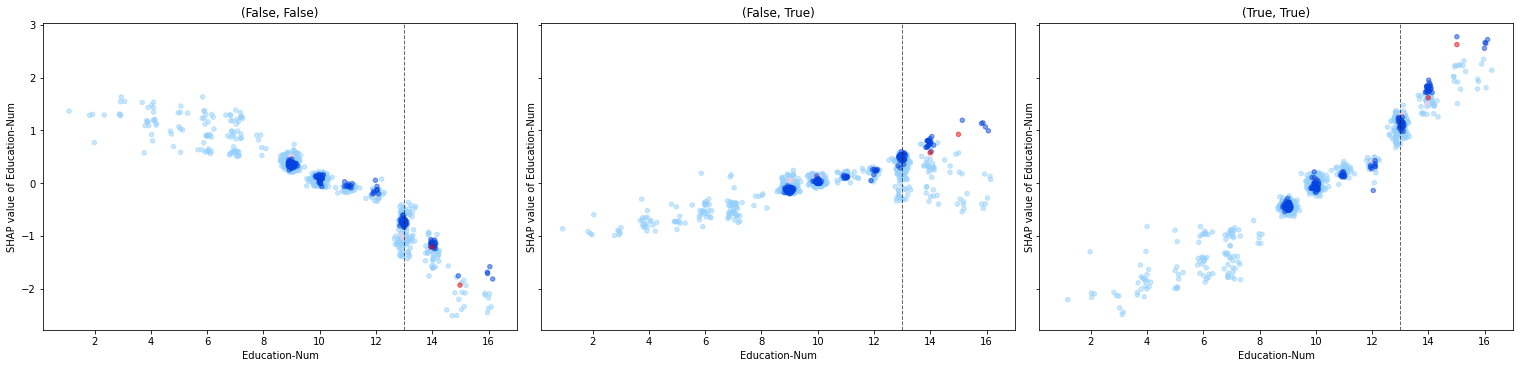

In [32]:
plot(next(feature_it))

equal to parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 2},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 2}]


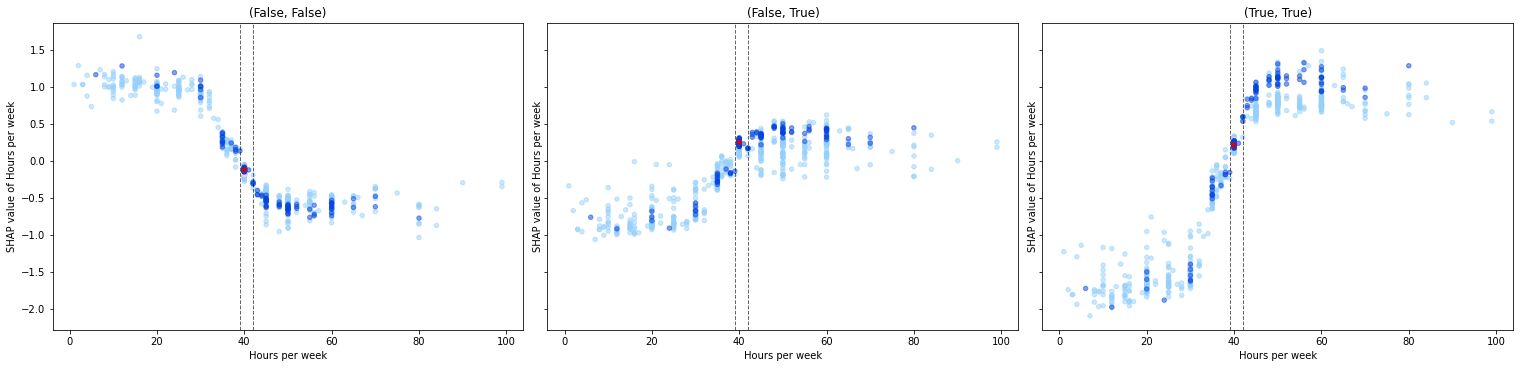

In [33]:
plot(next(feature_it))

Occupation 10-14 are very similar in terms of their outcomes, and in a local high for the difference class. Above and below the prediction flips to $(False, False)$

Occupation == 10.0
[Lower CF: Occupation == 9.0 --> {'(False, False)': 2},
 Upper CF: Occupation == 14.0 --> {'(False, False)': 2}]


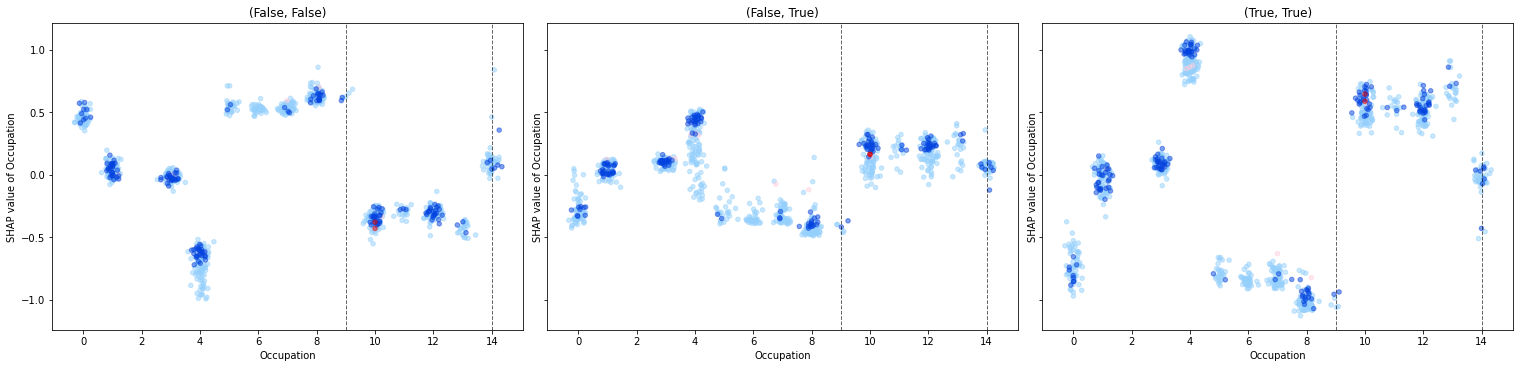

In [34]:
plot(next(feature_it))

Sex is 1 (Male) and predictions flip if set to 0 (Female) to $(False, False)$.

Sex == 1.0
[Lower CF: Sex == 0.0 --> {'(False, False)': 2}]


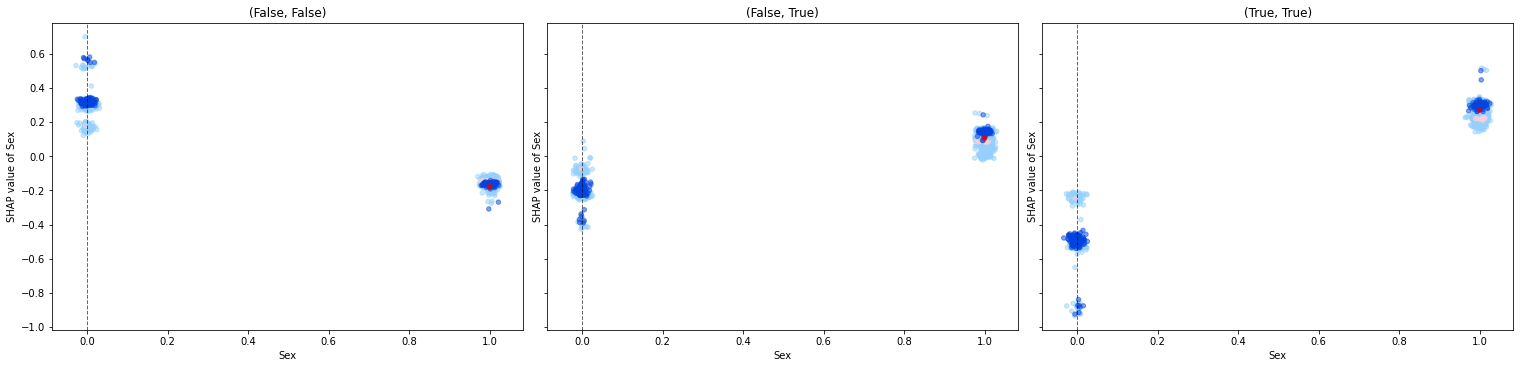

In [35]:
plot(next(feature_it))

Equal to parent

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 2}]


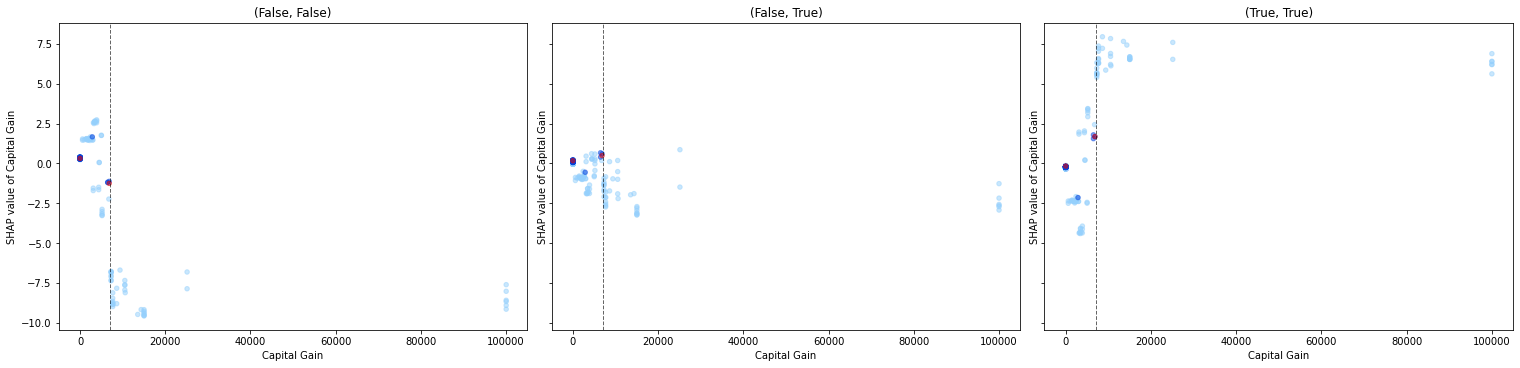

In [36]:
plot(next(feature_it))

Relationship <= 0.0 and 36.0 < Age <= 65.0 and `Education-Num` > 13.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       172
        True       0.50      1.00      0.67         2

    accuracy                           0.99       174
   macro avg       0.75      0.99      0.83       174
weighted avg       0.99      0.99      0.99       174



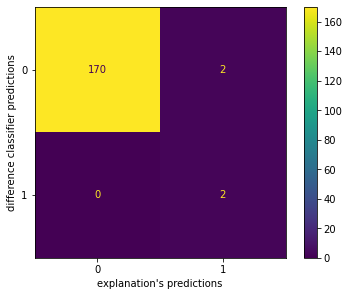

In [37]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Education-Num', 'Hours per week', 'Occupation', 'Sex', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

In [38]:
explanations_l1 = [(rule, constraint, instance_indices)]

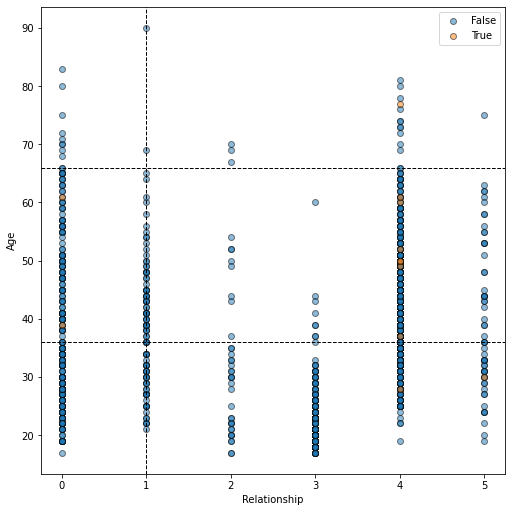

In [39]:
plot_2d(node, 'Relationship', 'Age')

### Node 2 (RRLLR)

In [40]:
node = node.root.get('RR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLR,
 (False, False)    151
 (True, True)       96
 (False, True)      10
 dtype: int64,
 29.41299533668855)

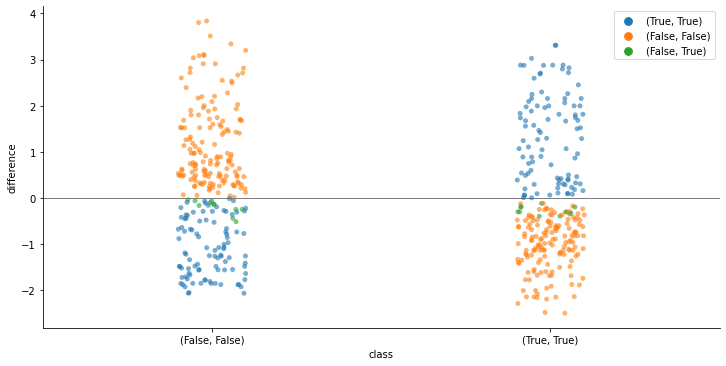

{'(False, False)': '-0.51 to -0.04', '(True, True)': '-0.39 to -0.11'}


In [41]:
node.plot_outcome_differences()

In [42]:
feature_it = iter(node.features_with_counterfactuals)

Relationship is 4 or 5, lower values flip the prediction to $(False, False)$.

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 10}]


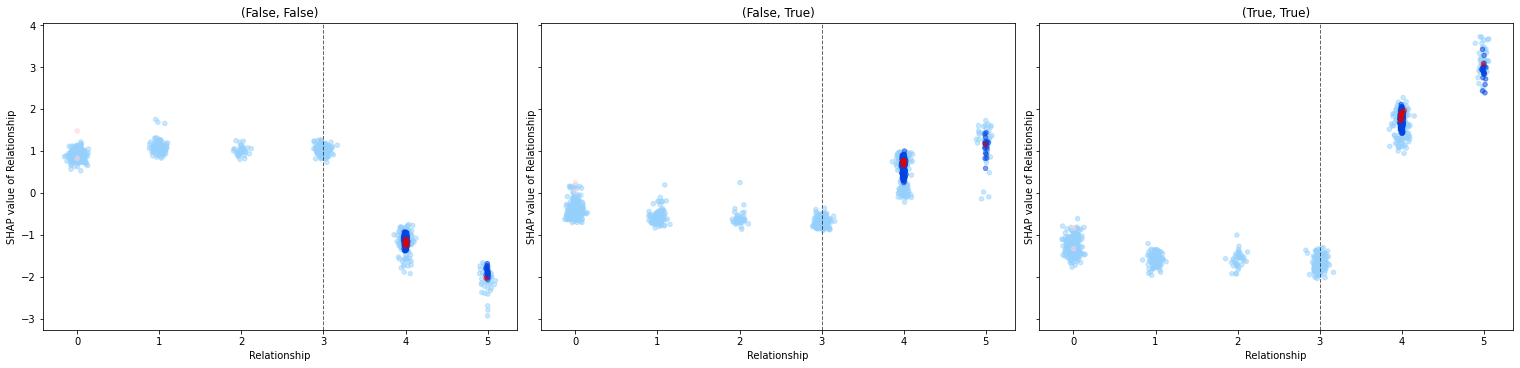

In [43]:
plot(next(feature_it))

Same as parent

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 10},
 Upper CF: Age == 80.0 --> {'(False, False)': 9, '(True, True)': 1}]


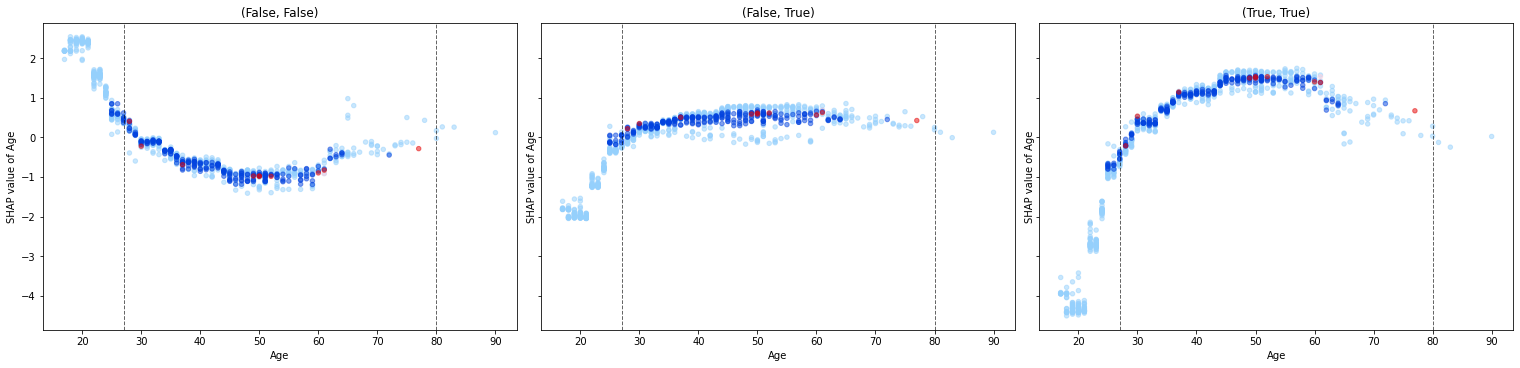

In [44]:
plot(next(feature_it))

Now has upper CF as well

9.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 10},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 10}]


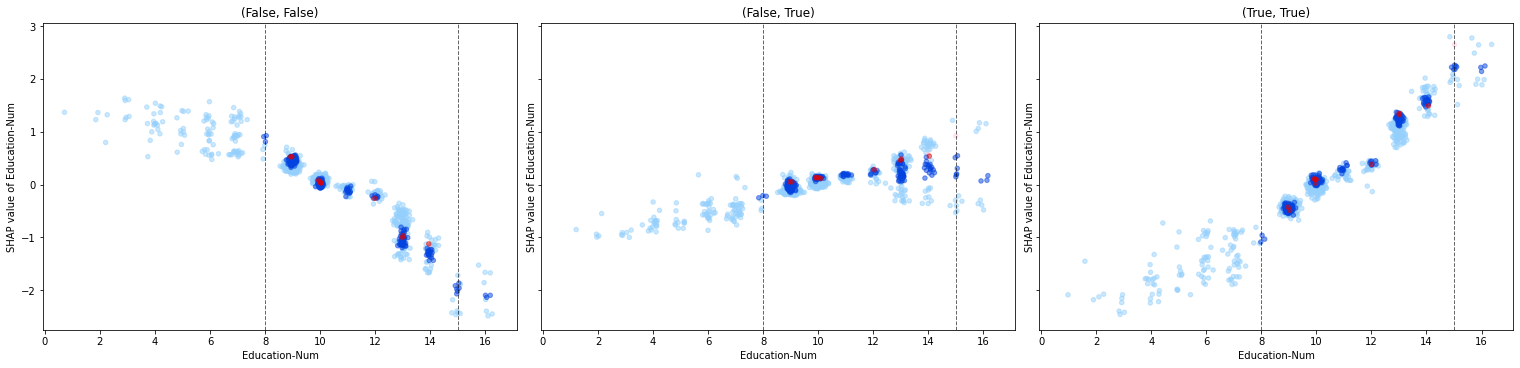

In [45]:
plot(next(feature_it))

Same as parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 10},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 10}]


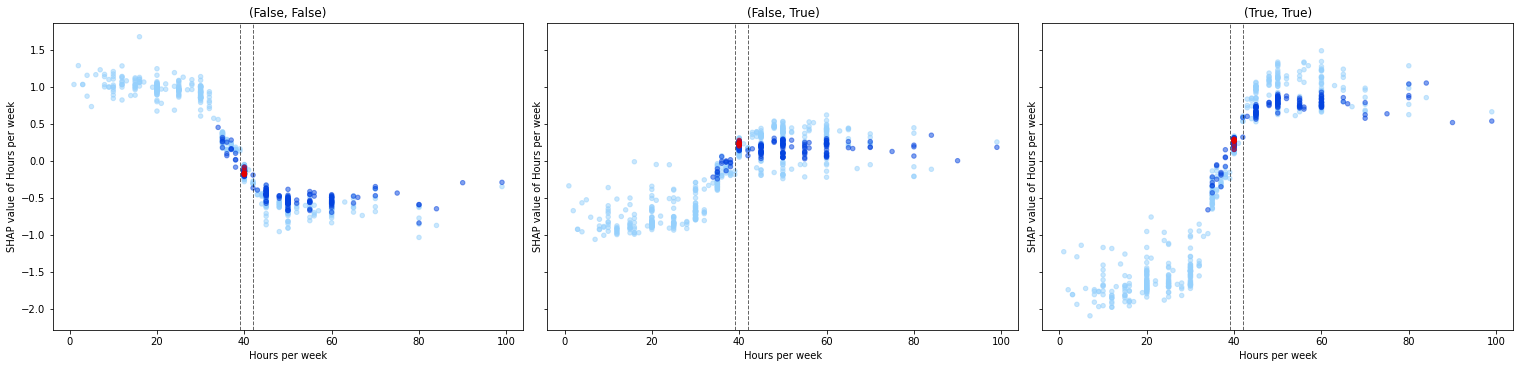

In [46]:
plot(next(feature_it))

CF now much lower

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 10}]


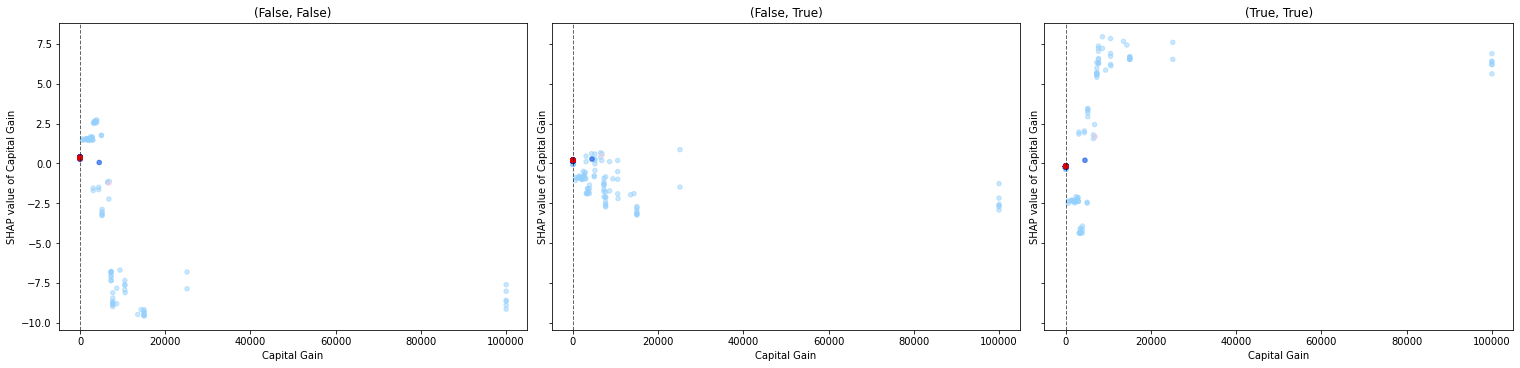

In [47]:
plot(next(feature_it))

Marital Status is 2 (Married-civ-spouse), but a similar outcome is expected for values 0, 1 and 3 but changes at 4 (Never-married) to $(False, False)$

Marital Status == 2.0
[Upper CF: Marital Status == 4.0 --> {'(False, False)': 10}]


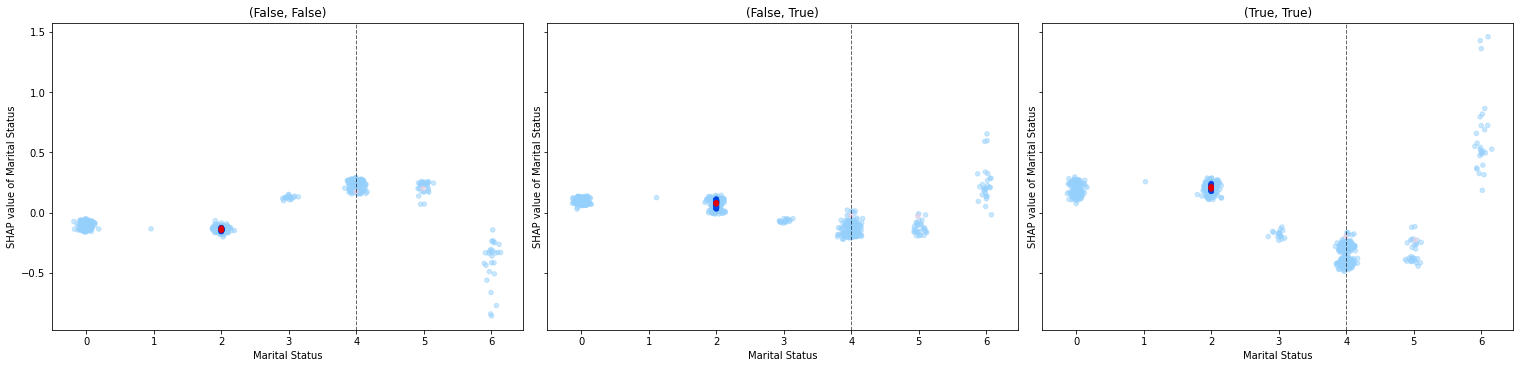

In [48]:
plot(next(feature_it))

No clear trend

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 10}]


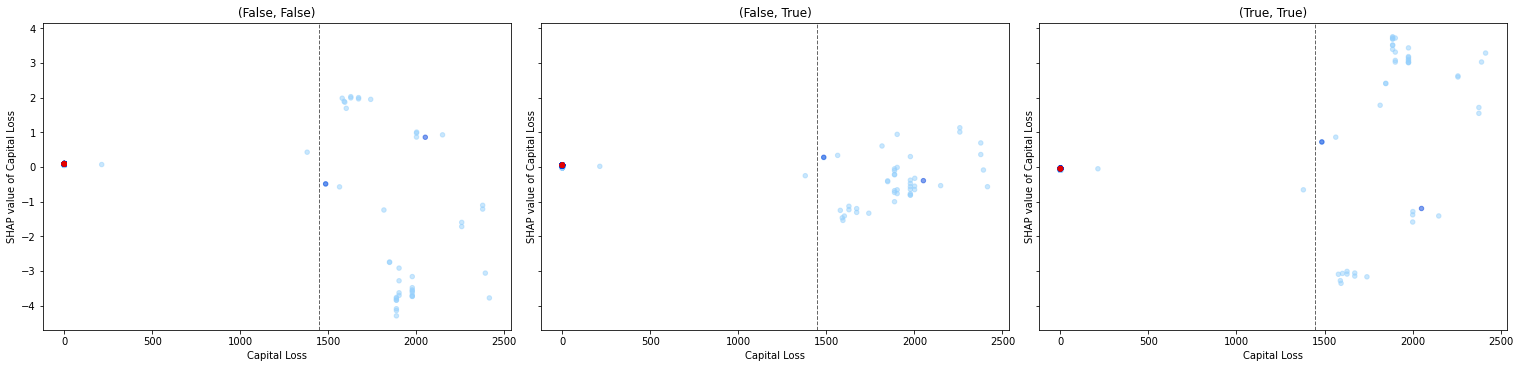

In [49]:
plot(next(feature_it))

Very outlying CF.

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 10}]


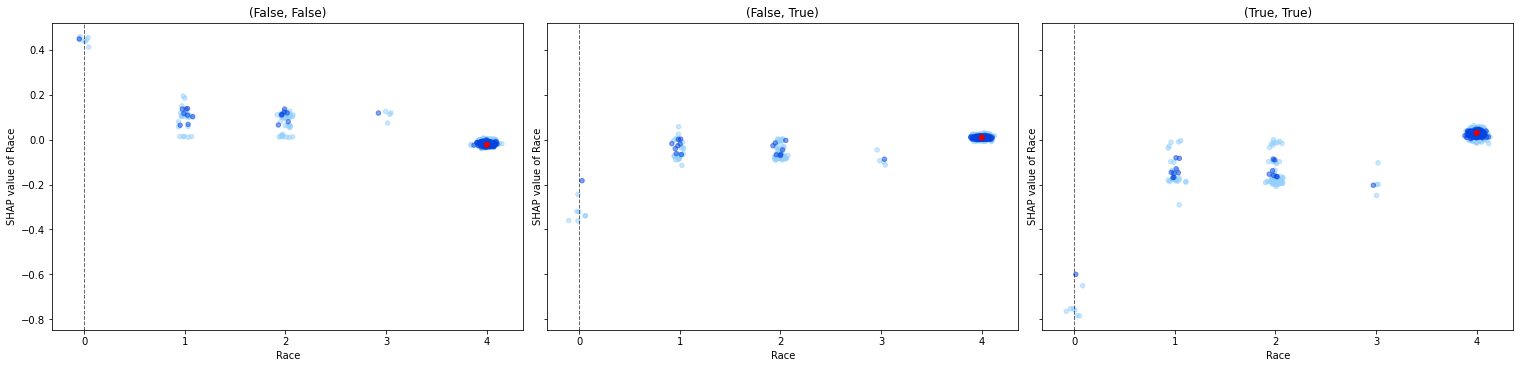

In [50]:
plot(next(feature_it))

Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
              precision    recall  f1-score   support

       False       1.00      0.59      0.74       247
        True       0.09      1.00      0.16        10

    accuracy                           0.60       257
   macro avg       0.54      0.79      0.45       257
weighted avg       0.96      0.60      0.72       257



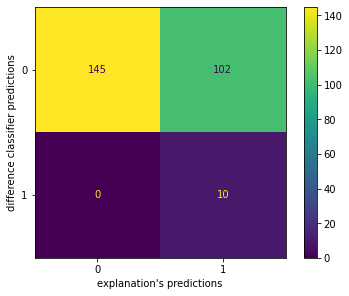

In [51]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain', 'Marital Status')
print(rule)
node.evaluate_rules(rule)

In [52]:
explanations_l1.append((rule, constraint, instance_indices))

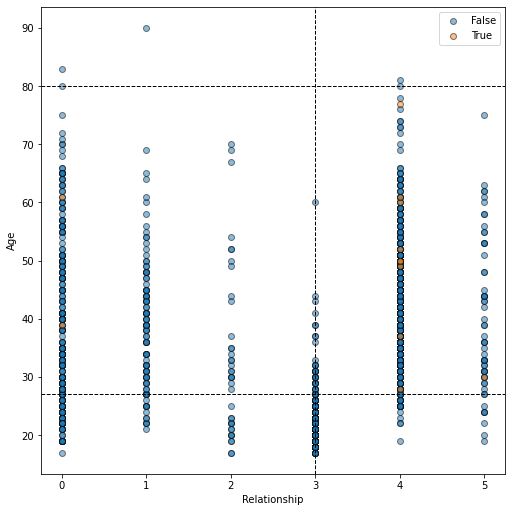

In [53]:
plot_2d(node, 'Relationship', 'Age')

### Node 2.1 (RRLLRL)

In [54]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLRL,
 (True, True)      65
 (False, False)     7
 (False, True)      3
 dtype: int64,
 13.966630453676805)

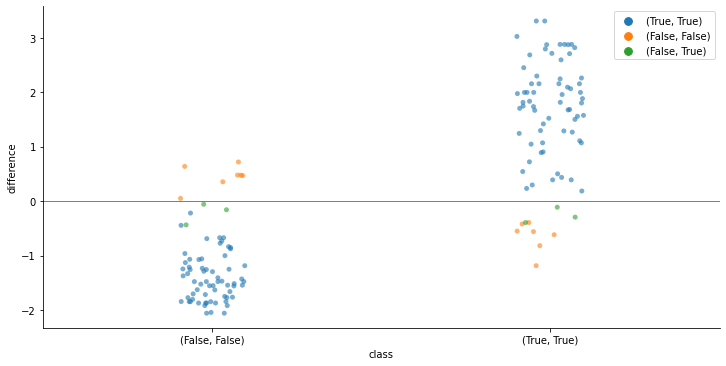

{'(False, False)': '-0.44 to -0.06', '(True, True)': '-0.39 to -0.11'}


In [55]:
node.plot_outcome_differences()

In [56]:
feature_it = iter(node.features_with_counterfactuals)

Same as parent

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 3}]


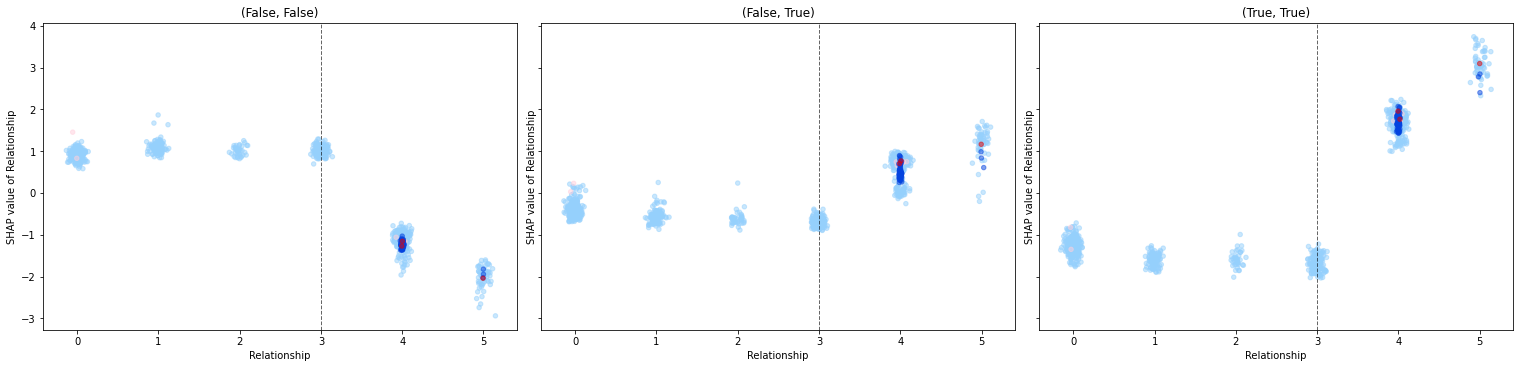

In [57]:
plot(next(feature_it))

Education-Num has now local differences for 13-14, lower CF is higher than in parent

13.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 3},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 3}]


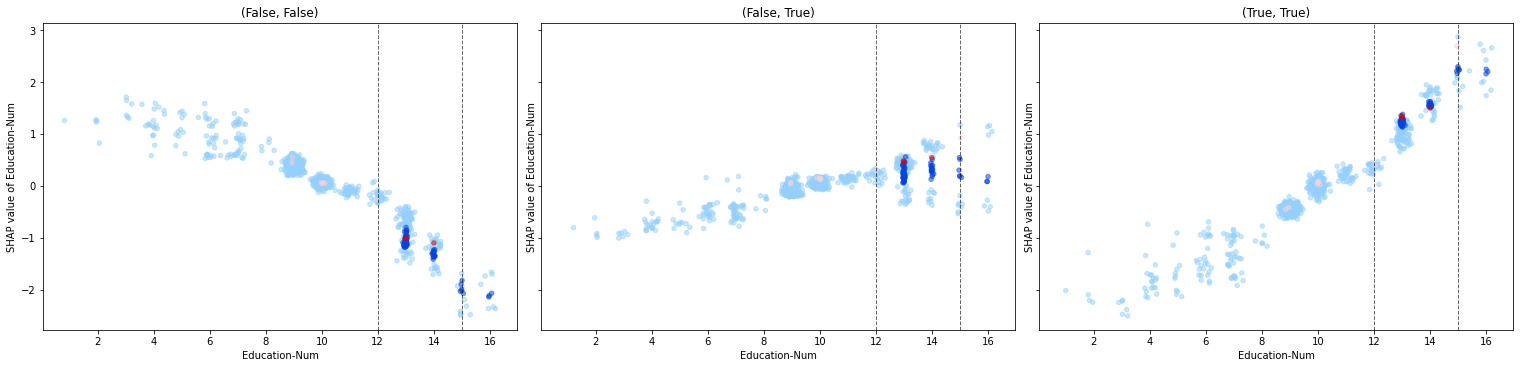

In [58]:
plot(next(feature_it))

Differences are in lower half of the parent's range, CF closer.

28.0 <= Age <= 37.0
[Lower CF: Age == 27.0 --> {'(False, False)': 3},
 Upper CF: Age == 44.0 --> {'(True, True)': 3}]


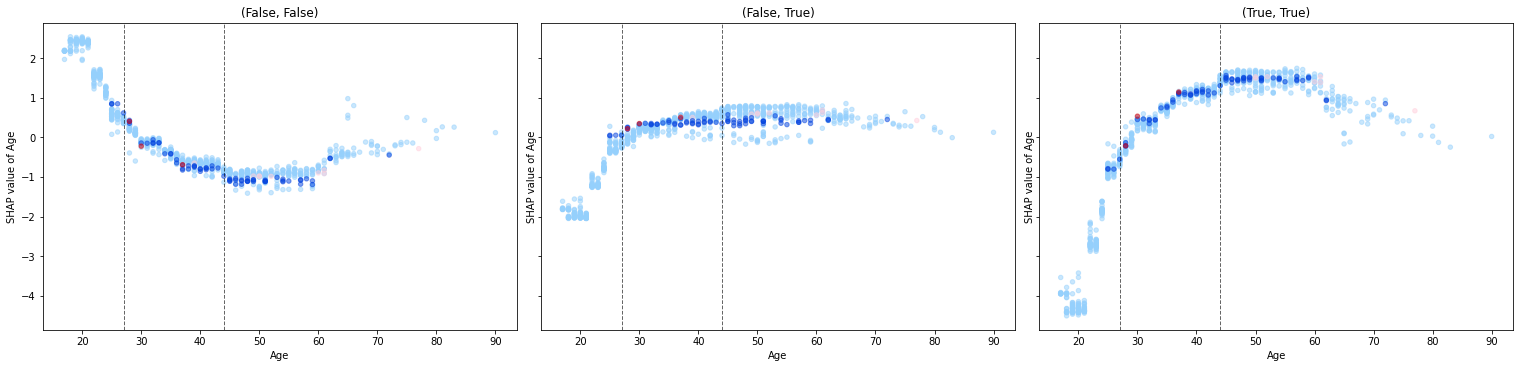

In [59]:
plot(next(feature_it))

CF not clear, not including it

7.0 <= Occupation <= 10.0
[Lower CF: Occupation == 3.0 --> {'(True, True)': 2, '(False, False)': 1}]


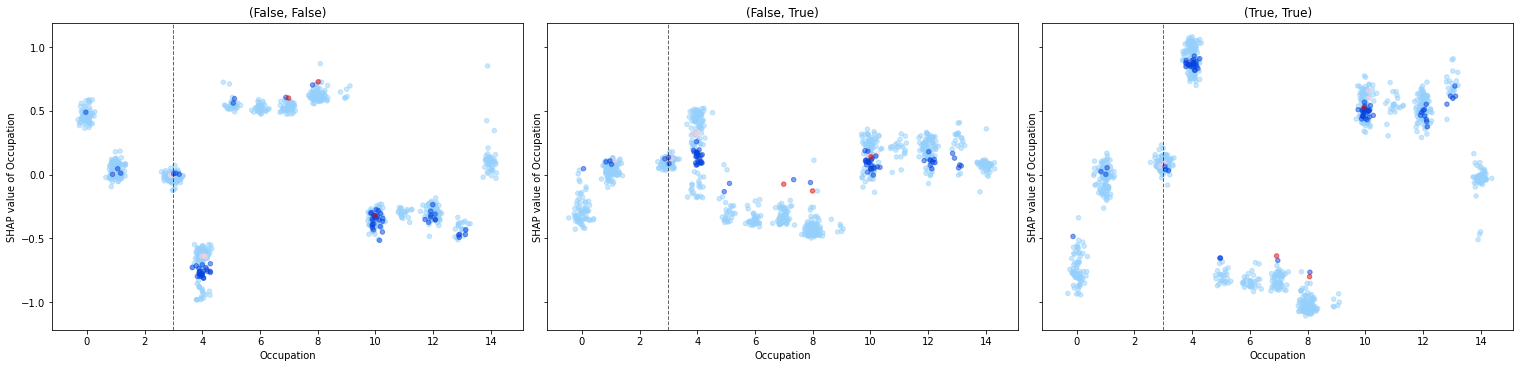

In [60]:
plot(next(feature_it))

Same as parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 3},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 3}]


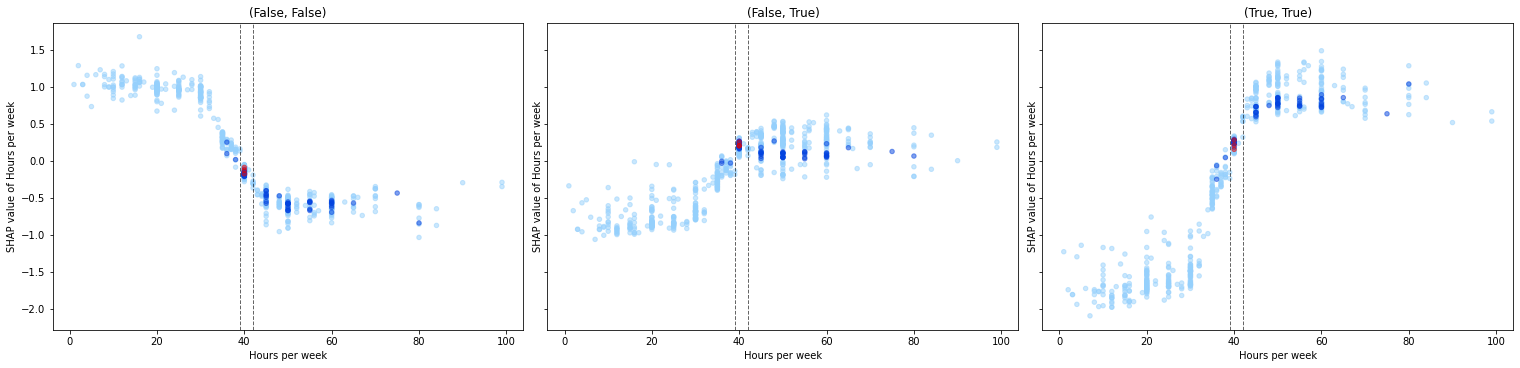

In [61]:
plot(next(feature_it))

Same as parent

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 3}]


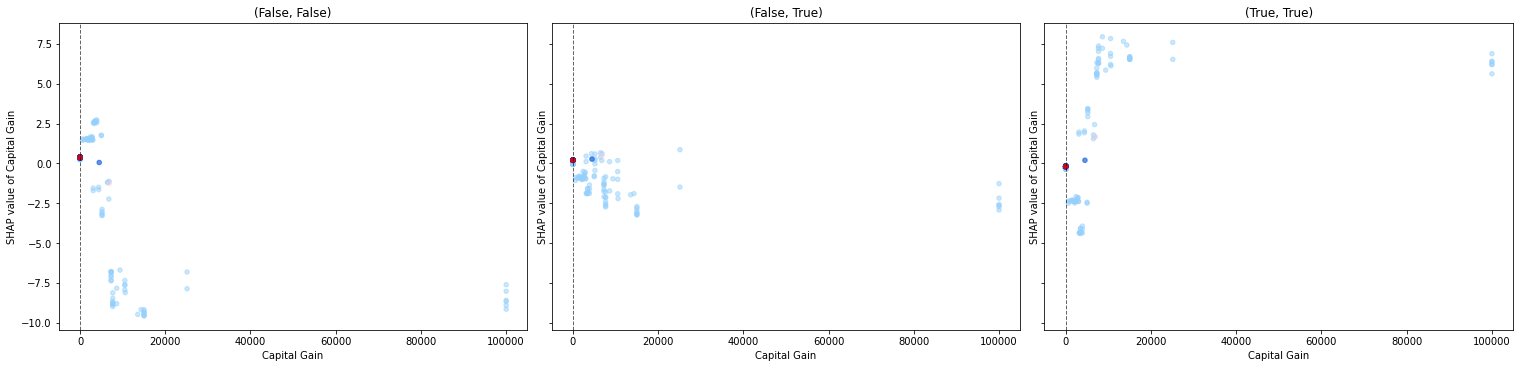

In [62]:
plot(next(feature_it))

Same as parent

Marital Status == 2.0
[Upper CF: Marital Status == 4.0 --> {'(False, False)': 3}]


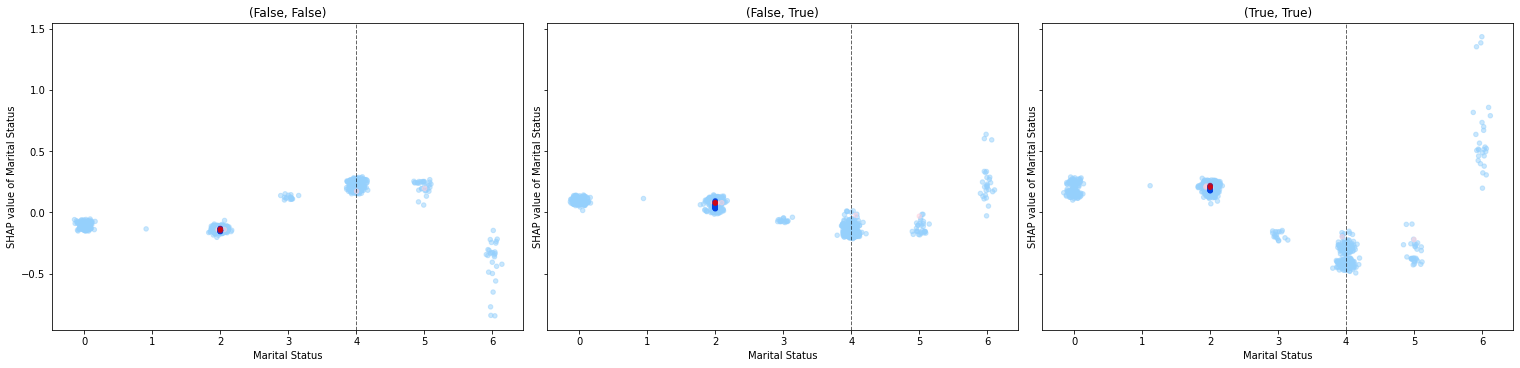

In [63]:
plot(next(feature_it))

Same as parent

Capital Loss == 0.0
[Upper CF: Capital Loss == 732.0 --> {'(False, False)': 3}]


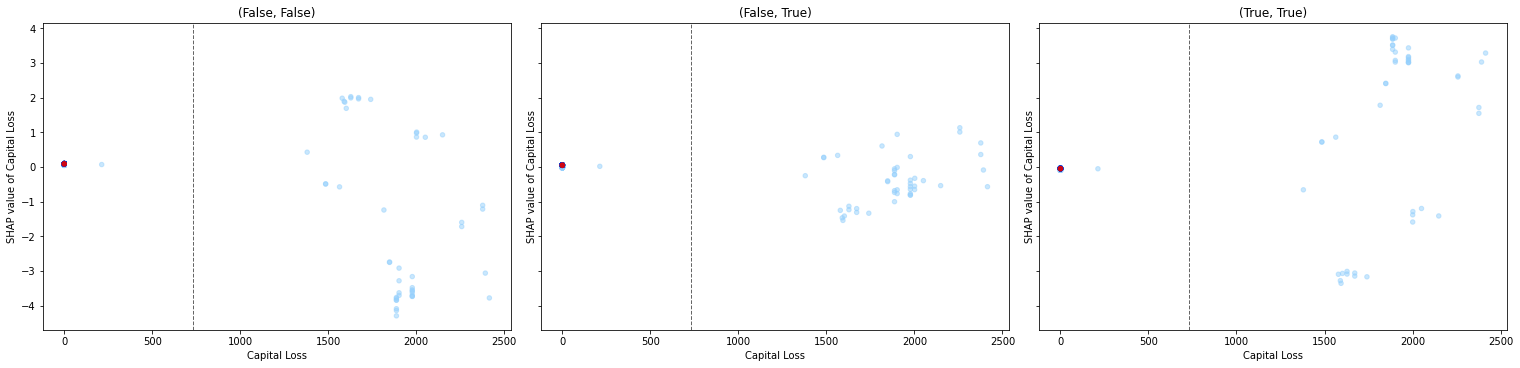

In [64]:
plot(next(feature_it))

Same as parent

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 3}]


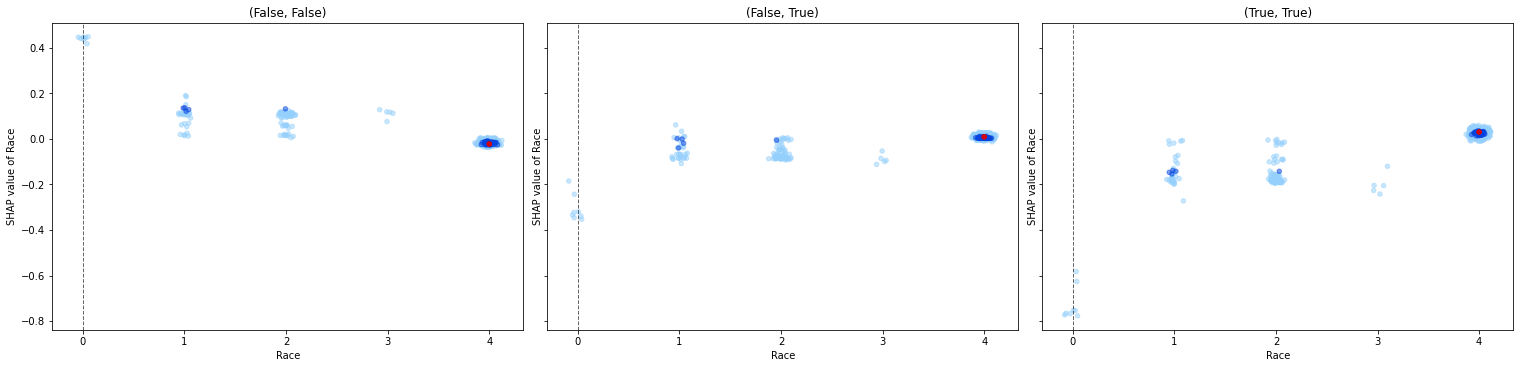

In [65]:
plot(next(feature_it))

Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 43.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
              precision    recall  f1-score   support

       False       1.00      0.88      0.93        72
        True       0.25      1.00      0.40         3

    accuracy                           0.88        75
   macro avg       0.62      0.94      0.67        75
weighted avg       0.97      0.88      0.91        75



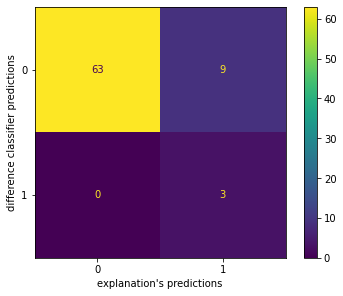

In [66]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Education-Num', 'Age', 'Hours per week', 'Capital Gain', 'Marital Status')
print(rule)
node.evaluate_rules(rule)

In [67]:
explanations_l2 = [explanations_l1[0]]
explanations_l2.append((rule, constraint, instance_indices))

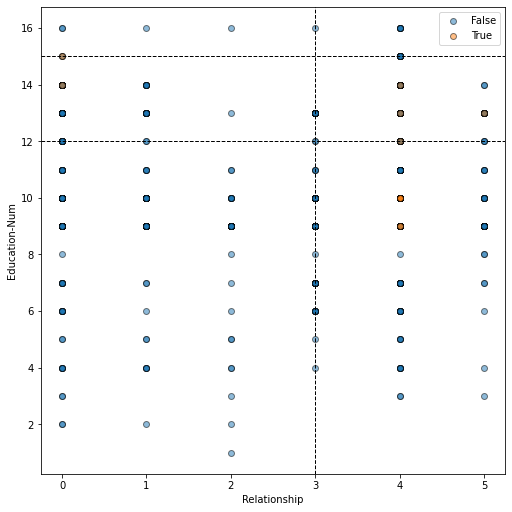

In [68]:
plot_2d(node, 'Relationship', 'Education-Num')

### Node 2.2 (RRLLRRLR)

In [69]:
node = node.root.get('RRLLRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLRRLR,
 (False, False)    89
 (True, True)      30
 (False, True)      7
 dtype: int64,
 6.409628398769407)

The instances in this cluster are even more similar than those of the previously analyzed cluster.

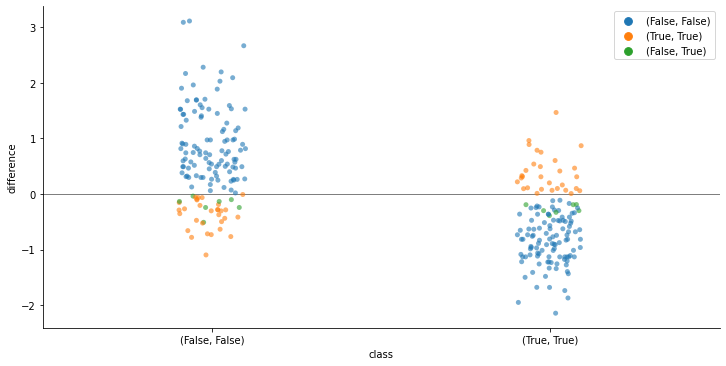

{'(False, False)': '-0.51 to -0.04', '(True, True)': '-0.39 to -0.19'}


In [70]:
node = node.parent
node.plot_outcome_differences()

In [71]:
feature_it = iter(node.features_with_counterfactuals)

Same as parent

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 7}]


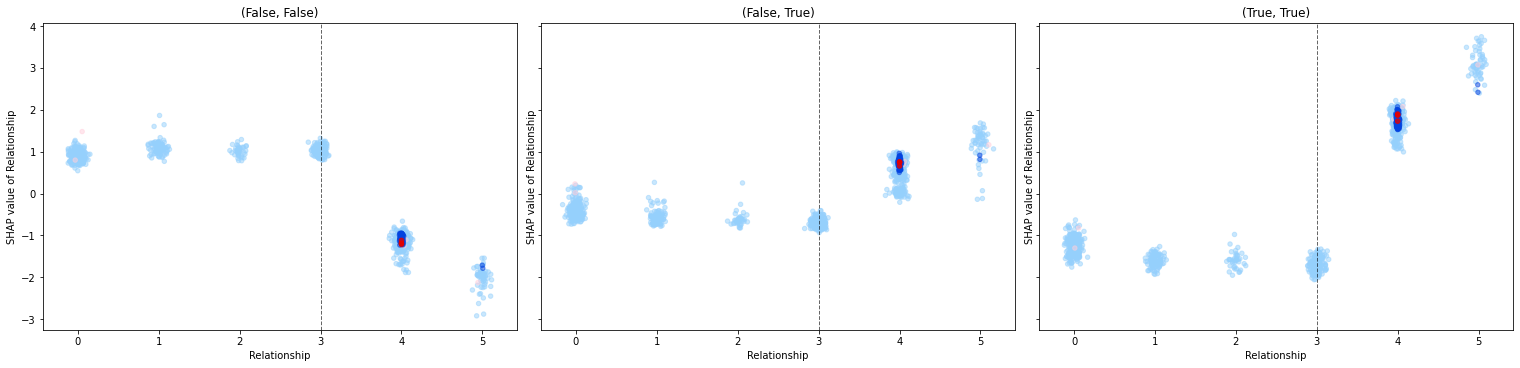

In [72]:
plot(next(feature_it))

In this cluster, there is less feature interaction (vertical spread of SHAP values) for this dependence plot visible. Lower CF now higher

49.0 <= Age <= 77.0
[Lower CF: Age == 33.0 --> {'(False, False)': 7},
 Upper CF: Age == 80.0 --> {'(False, False)': 7}]


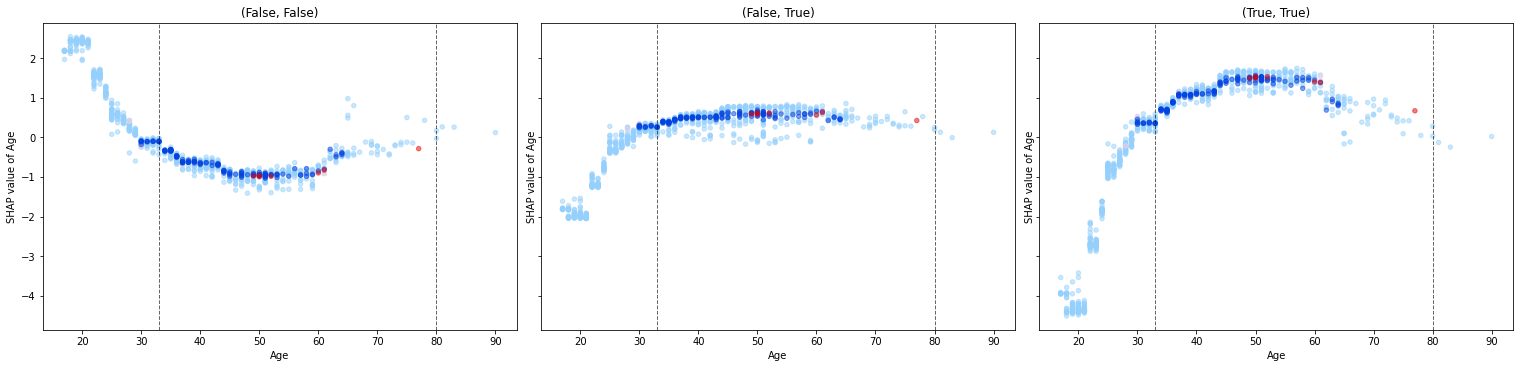

In [73]:
plot(next(feature_it))

Same as parent

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 7},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 7}]


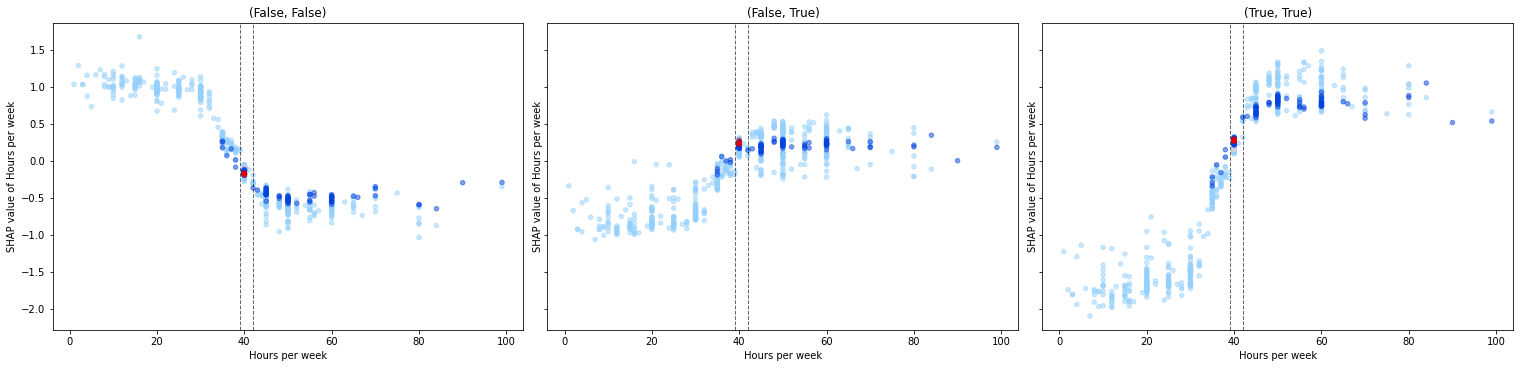

In [74]:
plot(next(feature_it))

Same as parent

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 7}]


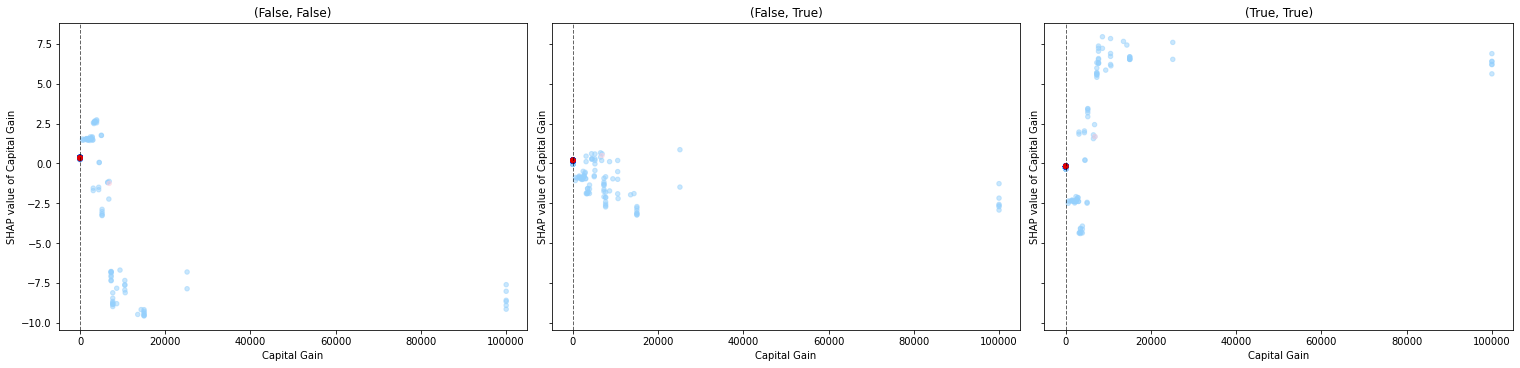

In [75]:
plot(next(feature_it))

No clear effect visible, excluding it.

1.0 <= Occupation <= 4.0
[Upper CF: Occupation == 5.0 --> {'(False, False)': 7}]


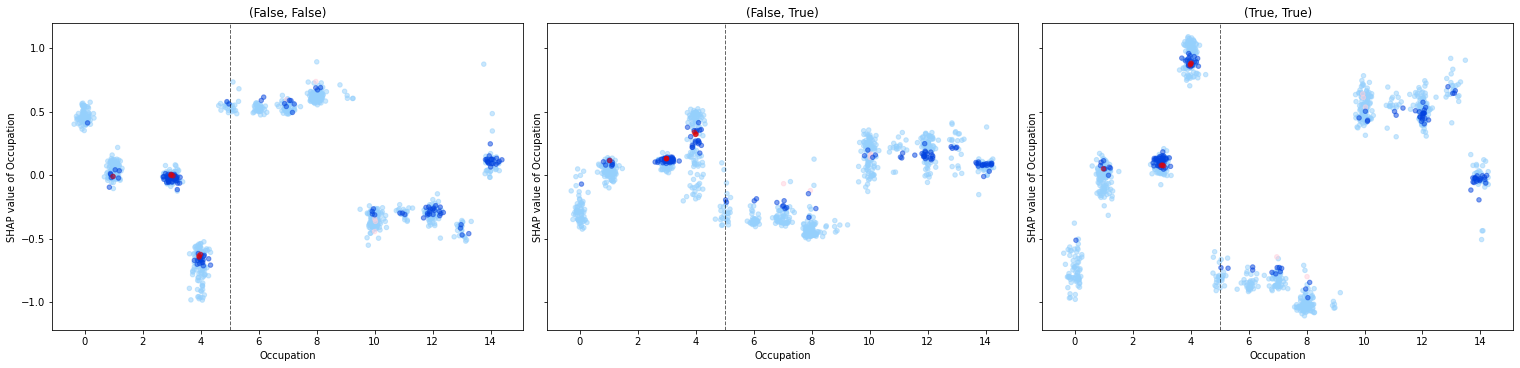

In [76]:
plot(next(feature_it))

values are lower than it sibling node, counterfactuals are close.

9.0 <= Education-Num <= 12.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 7},
 Upper CF: Education-Num == 13.0 --> {'(True, True)': 7}]


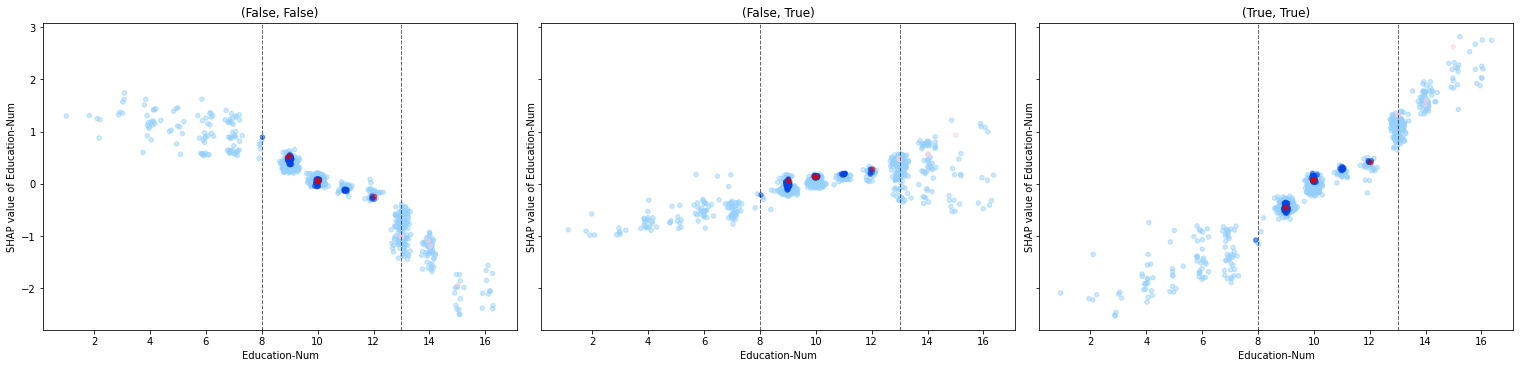

In [77]:
plot(next(feature_it))

similar to parent.

Marital Status == 2.0
[Upper CF: Marital Status == 4.0 --> {'(False, False)': 7}]


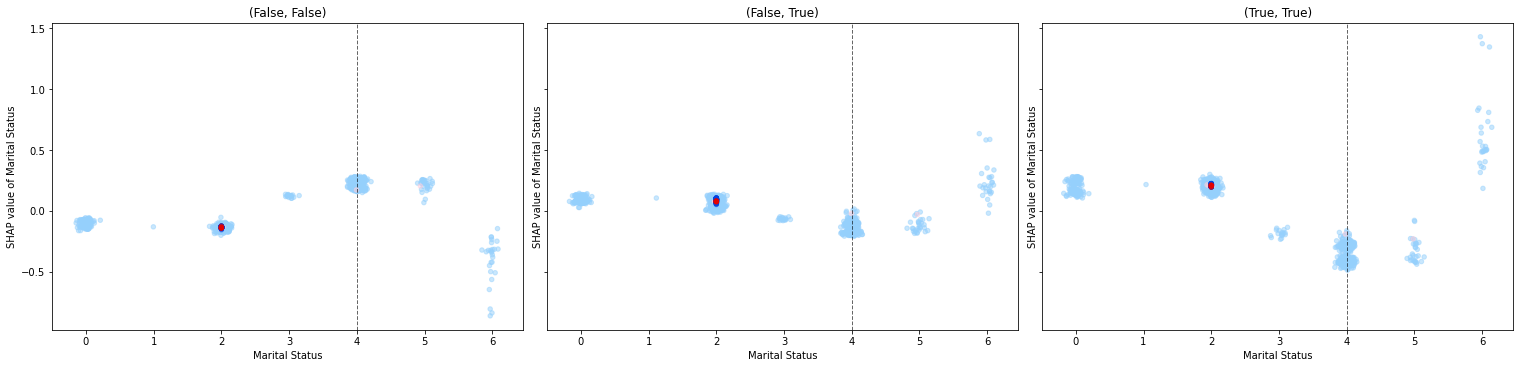

In [78]:
plot(next(feature_it))

The upper two values clearly tend to increase the outcome of $(False, False)$, with a CF.

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 7}]


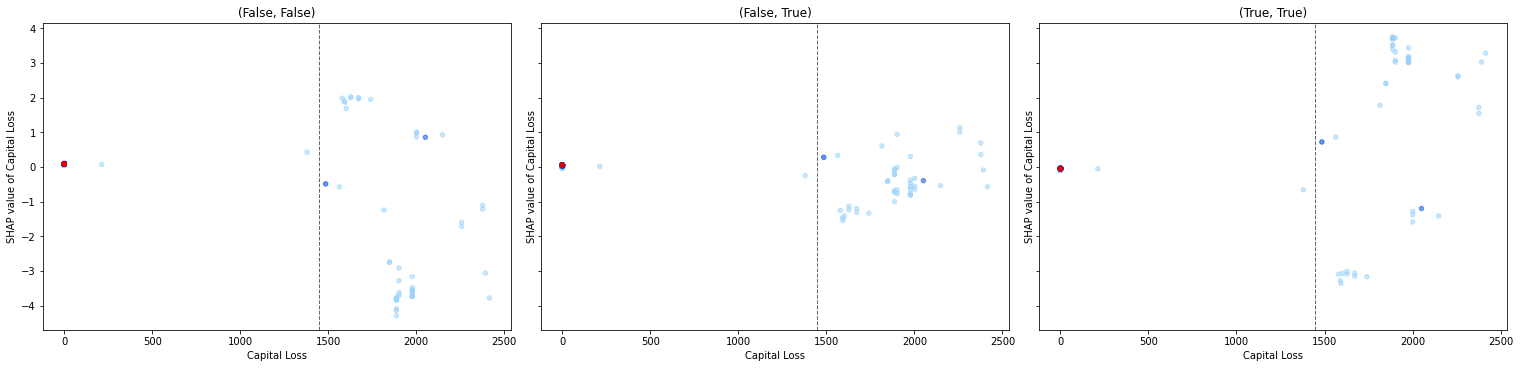

In [79]:
plot(next(feature_it))

same as parent

4.0 <= Workclass <= 5.0
[Upper CF: Workclass == 6.0 --> {'(False, False)': 7}]


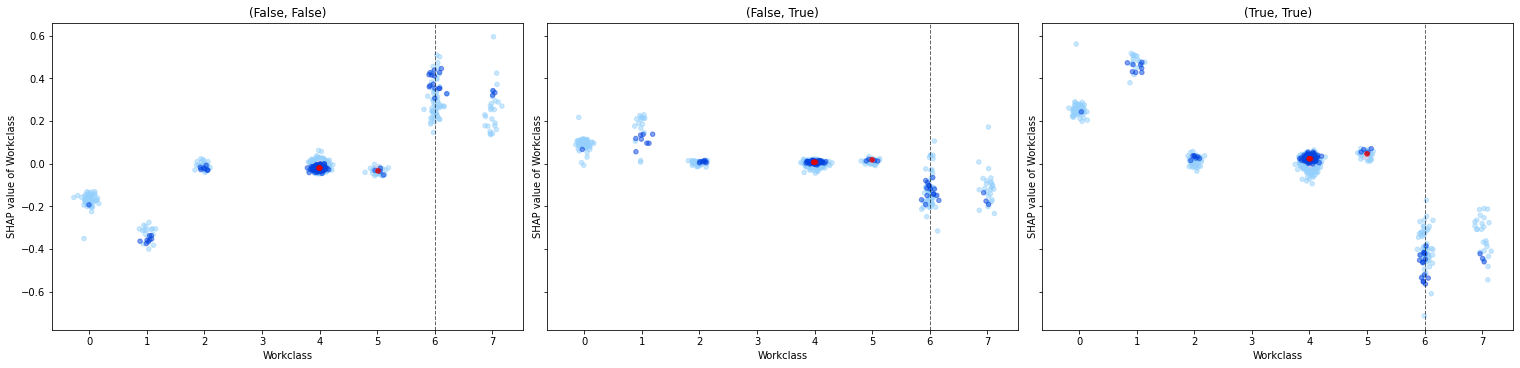

In [80]:
plot(next(feature_it))

same as parent

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 7}]


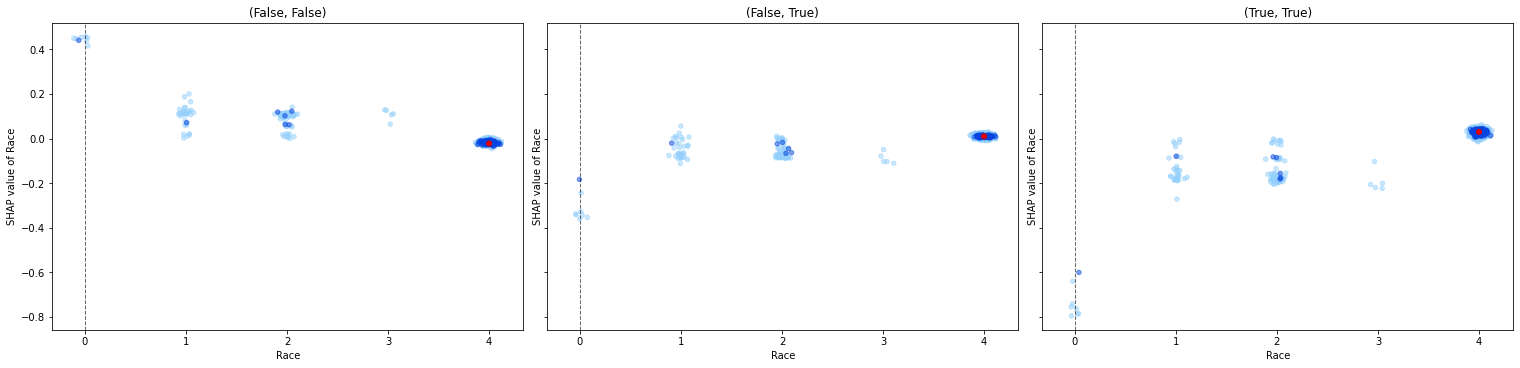

In [81]:
plot(next(feature_it))

Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and `Marital Status` <= 3.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.67      0.80       135
        True       0.13      1.00      0.24         7

    accuracy                           0.68       142
   macro avg       0.57      0.83      0.52       142
weighted avg       0.96      0.68      0.77       142



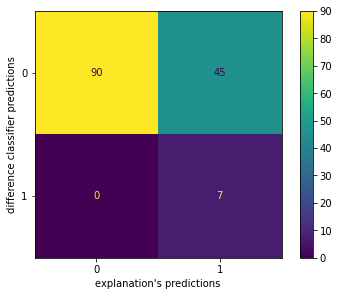

In [82]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain', 'Marital Status', 'Workclass')
print(rule)
node.evaluate_rules(rule)

In [83]:
explanations_l2.append((rule, constraint, instance_indices))

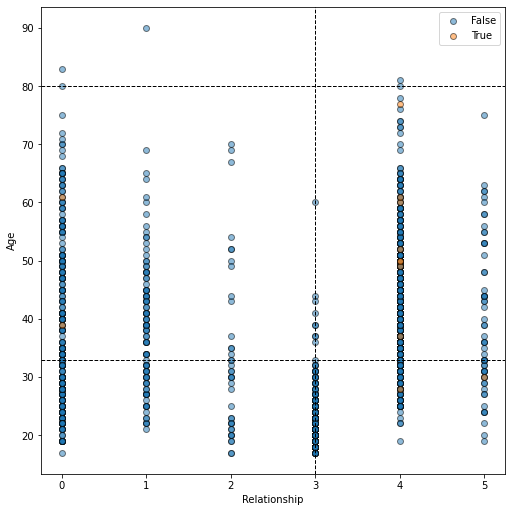

In [84]:
plot_2d(node, 'Relationship', 'Age')

### Evaluation

#### Global Fidelity

##### Global

In [85]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

1. 27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       965
        True       0.04      1.00      0.08        12

    accuracy                           0.73       977
   macro avg       0.52      0.86      0.46       977
weighted avg       0.99      0.73      0.83       977



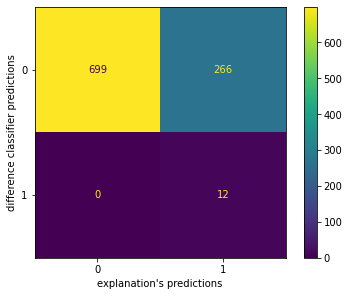

In [86]:
print_rules(rules)
node.root.evaluate_rules(*rules)

##### Level 1

In [87]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

1. Relationship <= 0.0 and 36.0 < Age <= 65.0 and `Education-Num` > 13.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
              precision    recall  f1-score   support

       False       1.00      0.88      0.94       965
        True       0.09      1.00      0.17        12

    accuracy                           0.88       977
   macro avg       0.55      0.94      0.55       977
weighted avg       0.99      0.88      0.93       977



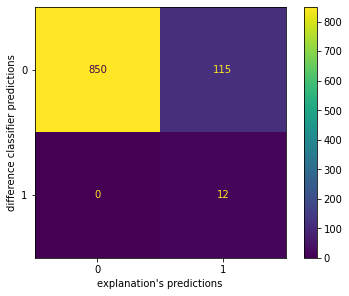

In [88]:
print_rules(rules)
node.root.evaluate_rules(*rules)

##### Level 2

In [89]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

1. Relationship <= 0.0 and 36.0 < Age <= 65.0 and `Education-Num` > 13.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 43.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and `Marital Status` <= 3.0
3. Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and `Marital Status` <= 3.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.93      0.96       965
        True       0.15      1.00      0.27        12

    accuracy                           0.93       977
   macro avg       0.58      0.97      0.62       977
weighted avg       0.99      0.93      0.96       977



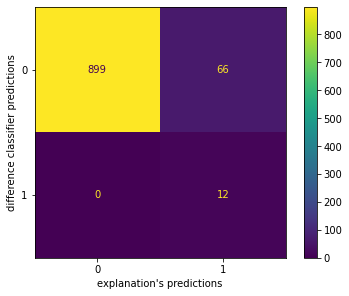

In [90]:
print_rules(rules)
node.root.evaluate_rules(*rules)

#### Counterfactual Fidelity Error

##### Global

In [91]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [92]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide


In [93]:
rmse

Age                 21.245588
Workclass                 NaN
Education-Num        3.201562
Marital Status            NaN
Occupation                NaN
Relationship              NaN
Race                      NaN
Sex                       NaN
Capital Gain      6718.266015
Capital Loss              NaN
Hours per week       0.000000
Country                   NaN
dtype: float64

In [94]:
boundary_miss_rate

Age               0.000000
Workclass         1.000000
Education-Num     0.478261
Marital Status    1.000000
Occupation        1.000000
Relationship      1.000000
Race              1.000000
Sex               1.000000
Capital Gain      0.076923
Capital Loss      1.000000
Hours per week    0.000000
Country           1.000000
dtype: float64

In [95]:
boundary_add_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        NaN
Relationship      NaN
Race              NaN
Sex               NaN
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

##### Level 1

In [96]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [97]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [98]:
rmse

Age                 20.527421
Workclass                 NaN
Education-Num        2.458751
Marital Status       0.894427
Occupation           1.000000
Relationship         0.288675
Race                      NaN
Sex                  0.000000
Capital Gain      2025.633419
Capital Loss              NaN
Hours per week       0.000000
Country                   NaN
dtype: float64

In [99]:
boundary_miss_rate

Age               0.000000
Workclass         1.000000
Education-Num     0.043478
Marital Status    0.166667
Occupation        0.826087
Relationship      0.368421
Race              1.000000
Sex               0.777778
Capital Gain      0.076923
Capital Loss      1.000000
Hours per week    0.000000
Country           1.000000
dtype: float64

In [100]:
boundary_add_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    0.0
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

##### Level 2

In [101]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [102]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [103]:
rmse

Age                 11.953033
Workclass            0.000000
Education-Num        1.066004
Marital Status       0.894427
Occupation           1.000000
Relationship         0.288675
Race                      NaN
Sex                  0.000000
Capital Gain      2025.633419
Capital Loss              NaN
Hours per week       0.000000
Country                   NaN
dtype: float64

In [104]:
boundary_miss_rate

Age               0.000000
Workclass         0.650000
Education-Num     0.043478
Marital Status    0.166667
Occupation        0.826087
Relationship      0.368421
Race              1.000000
Sex               0.777778
Capital Gain      0.076923
Capital Loss      1.000000
Hours per week    0.000000
Country           1.000000
dtype: float64

In [105]:
boundary_add_rate

Age               0.0
Workclass         0.0
Education-Num     0.0
Marital Status    0.0
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

#### Complexity

##### Global

In [106]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [107]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 6 (6.0 per rule)


##### Level 1

In [108]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [109]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 19 (9.5 per rule)


##### Level 2

In [110]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [111]:
print_complexity(constraints)

Number of rules: 3
Number of constraints: 29 (9.7 per rule)


#### Stability

##### Global

In [112]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [113]:
with open('explanation-shap-orig-01-l0.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

##### Level 1

In [114]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [115]:
with open('explanation-shap-orig-01-l1.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

##### Level 2

In [116]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [117]:
with open('explanation-shap-orig-01-l2.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

# Summary

## Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
global | 0.04 | 1.0 | 0.08
level 1 | 0.09 | 1.0 | 0.17
level 2 | 0.15 | 1.0 | 0.27

## Generation Time

Total: approx. 39min
- generation of difference classifier SHAP values: 36min 29s
- generation of hierarchical clustering: 18s
- generation of counterfactuals: 105s (20+31+21+13+20)

## Complexity

Intermediate Results: 42 dependence plots in total

Node | # Dependence Plots
--- | ---
main | 7
1 | 7
2 | 8
2.1 | 9
2.2 | 11

Final Explanation: As a proxy for the complexity of the final explanation I'm using the rule set derived from the counterfactuals.

Ruleset | # Rules | # Terms
 --- | --- | ---
global | 1 | 6
level 1 | 2 | 19
level 2 | 3 | 29